#Business problem

#Description

 The name of the problem is “buy low, sell high”, This problem focusses on being able to make profitable stock market trading decisions in real time.
There are thousands of transactions happening every second in the stock market, but due to the lack of perfect market efficiency, there are many opportunities to make profits, but at the same time identifying which stock can make a profit at that particular time is a very complex problem. 


#Objective

The objective here is to use historical data, mathematical tools, and technological tools to build a highly predictive model which is as close to certainty as possible, and when presented with trading opportunities must choose whether to accept or reject a certain buying decision.  


#Business constraints

1. cost of misclassification of negative class can be very high
2.Not very strict latency constraints
3.Interpretability is not very important

# Metrics


1. primary metric used will be AUC-ROC curve because we need high TPR and low FPR as high FPR will increase the loss and low TPR will not generate more profits, hence one metric which uses both is ROC-AUC .
2. Macro f1 score

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
import plotly.express as px
import pickle
import warnings
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from scipy.stats import norm
import pickle
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
import plotly.express as px
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
from sklearn.metrics import log_loss 
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Dense,concatenate,Activation,Dropout,Input,Embedding,LSTM,Flatten,Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



#Downloading and extracting the Data

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c jane-street-market-prediction

  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 128kB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 59.5MB/s]
  0% 0.00/23.3k [00:00<?, ?B/s]
100% 23.3k/23.3k [00:00<00:00, 21.9MB/s]
 61% 10.0M/16.4M [00:00<00:00, 46.2MB/s]
100% 16.4M/16.4M [00:00<00:00, 64.8MB/s]
  0% 0.00/108k [00:00<?, ?B/s]
100% 108k/108k [00:00<00:00, 124MB/s]
100% 2.60G/2.61G [00:24<00:00, 83.2MB/s]
100% 2.61G/2.61G [00:24<00:00, 116MB/s] 


In [ ]:
!unzip -q /content/train.csv.zip -d .
!unzip -q /content/example_test.csv.zip -d .

# Reading the Data and performing EDA

In [ ]:
train=pd.read_csv('/content/train.csv')

In [ ]:
train.head()

date     weight    resp_1  ...  feature_128  feature_129  ts_id
0     0   0.000000  0.009916  ...     2.301488    11.445807      0
1     0  16.673515 -0.002828  ...    -1.304614     1.898684      1
2     0   0.000000  0.025134  ...     6.638248     9.427299      2
3     0   0.000000 -0.004730  ...     3.856384     1.013469      3
4     0   0.138531  0.001252  ...     0.362636     3.926633      4

[5 rows x 138 columns]

positive resp values mean that the label needs to be 1 (trade) and negative resp means the label needs to be 0 (pass on)

In [ ]:
train['label']=(train.loc[:, 'resp'] > 0).astype(int)

In [ ]:
print('number of rows in train : ',len(train))

number of rows in train :  2390491


In [ ]:
train.duplicated(keep='last')
print('number of rows in train : ',len(train))

number of rows in train :  2390491


There are no duplicates in the data

In [ ]:
# removing rows with weight = 0
train=train[train['weight']!=0]
train

date     weight    resp_1  ...  feature_129    ts_id  label
1           0  16.673515 -0.002828  ...     1.898684        1      0
4           0   0.138531  0.001252  ...     3.926633        4      0
6           0   0.190575 -0.001939  ...     3.921714        6      1
7           0   3.820844  0.017395  ...     4.429745        7      1
8           0   0.116557 -0.005460  ...     4.740577        8      0
...       ...        ...       ...  ...          ...      ...    ...
2390444   499  56.694795  0.001607  ...     0.215984  2390444      0
2390446   499   1.650055  0.004523  ...    -1.250209  2390446      0
2390478   499   0.895142  0.000486  ...    -2.064227  2390478      0
2390481   499   2.967272  0.000298  ...    -1.264984  2390481      0
2390489   499   0.283405 -0.000156  ...     0.627452  2390489      0

[1981287 rows x 139 columns]

In [ ]:
train.describe()

date        weight  ...         ts_id         label
count  1.981287e+06  1.981287e+06  ...  1.981287e+06  1.981287e+06
mean   2.526263e+02  3.657652e+00  ...  1.216696e+06  5.044130e-01
std    1.512144e+02  8.291001e+00  ...  6.853098e+05  4.999807e-01
min    0.000000e+00  6.912442e-03  ...  1.000000e+00  0.000000e+00
25%    1.130000e+02  3.786683e-01  ...  6.300985e+05  0.000000e+00
50%    2.610000e+02  1.072844e+00  ...  1.226025e+06  1.000000e+00
75%    3.850000e+02  3.196557e+00  ...  1.810380e+06  1.000000e+00
max    4.990000e+02  1.672937e+02  ...  2.390489e+06  1.000000e+00

[8 rows x 139 columns]

column "ts_id" represents time ordering so the next step is to sort the column in ascending order.

In [ ]:
train.sort_values(by=['ts_id'])

train.head()

date     weight    resp_1    resp_2  ...  feature_128  feature_129  ts_id  label
1     0  16.673515 -0.002828 -0.003226  ...    -1.304614     1.898684      1      0
4     0   0.138531  0.001252  0.002165  ...     0.362636     3.926633      4      0
6     0   0.190575 -0.001939 -0.002301  ...     0.361506     3.921714      6      1
7     0   3.820844  0.017395  0.021361  ...     2.201537     4.429745      7      1
8     0   0.116557 -0.005460 -0.007301  ...     1.778029     4.740577      8      0

[5 rows x 139 columns]

In [ ]:
y=train['label']

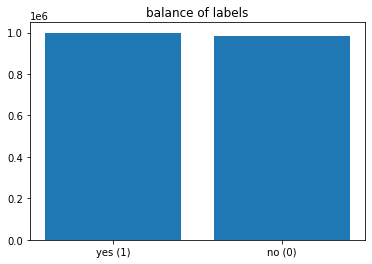

In [ ]:
plt.bar(['yes (1)','no (0)'],list(y.value_counts()))
plt.title('balance of labels')
plt.show()

The dataset is balanced

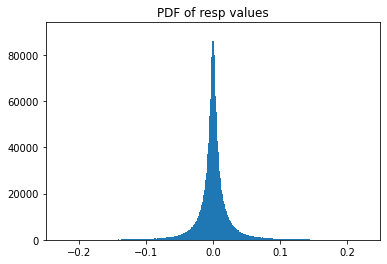

In [ ]:
a=plt.hist(train['resp'],bins=1000)
plt.xlim((-0.25, 0.25)) 
plt.title('PDF of resp values')
plt.show()

The distribution seems to have long tail which should be minimized as they might be outliers

In [ ]:
x=[]
y=[]
for i in tqdm(list(range(0,1001,1))):
  x.append(np.percentile(train['resp'],i/10))
  y.append(i/10)

100%|██████████| 1001/1001 [00:30<00:00, 32.64it/s]


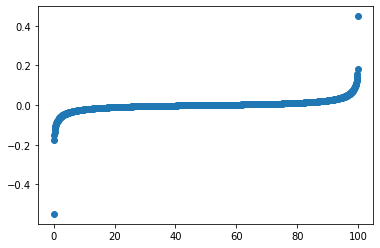

In [ ]:
plt.scatter(y,x)
plt.show()
del x,y

by plotting a scatter plot of resp values  we can definitely observe some outliers.

In [ ]:
x=train['resp']
for i in range(90,101,1):
  print(f'{i}th percentile value = {np.percentile(x,i)}')
del x

90th percentile value = 0.02326197533202365
91th percentile value = 0.025480925431740704
92th percentile value = 0.02804632349508833
93th percentile value = 0.031147756644046162
94th percentile value = 0.03491759563685327
95th percentile value = 0.03968914642978512
96th percentile value = 0.04602650487448233
97th percentile value = 0.05489942310413699
98th percentile value = 0.06837473535048619
99th percentile value = 0.09344264951482437
100th percentile value = 0.4484615812436584


In [ ]:
x=train['resp']
for i in range(0,10,1):
  print(f'{i}th percentile value = {np.percentile(x,i)}')
del x

0th percentile value = -0.5493844963458359
1th percentile value = -0.08746256347431064
2th percentile value = -0.0636176351217204
3th percentile value = -0.05109636007157079
4th percentile value = -0.04314235748069738
5th percentile value = -0.03738611111634093
6th percentile value = -0.03297829042665275
7th percentile value = -0.02944412675672609
8th percentile value = -0.02653884939386667
9th percentile value = -0.024092719044710813


In [ ]:
train=train[(train['resp']<=0.09344264951482437) & (train['resp']>=-0.08746256347431064)]

CDF of "resp_values"


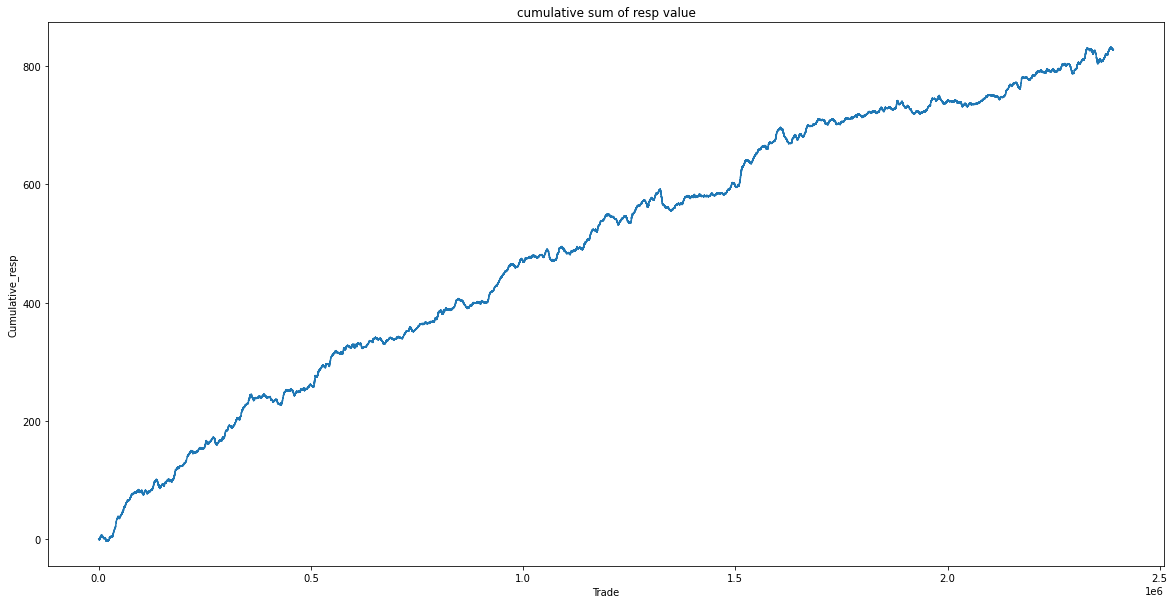

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train['resp'].cumsum())
plt.xlabel ("Trade")
plt.ylabel ("Cumulative_resp")
plt.title('cumulative sum of resp value')
plt.show()

resp values are more positive hence we have an upward curve, but we still have some noise hence it is also not monotonically increasing, we have some kinks in between


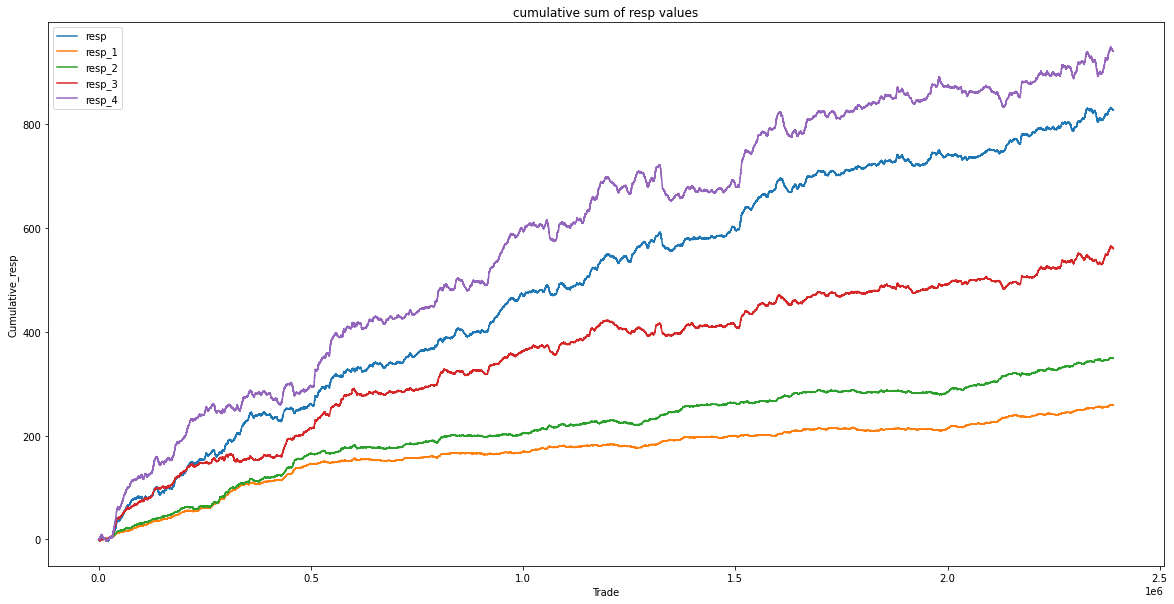

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train['resp'].cumsum())
plt.plot(train['resp_1'].cumsum())
plt.plot(train['resp_2'].cumsum())
plt.plot(train['resp_3'].cumsum())
plt.plot(train['resp_4'].cumsum())
plt.xlabel ("Trade")
plt.ylabel ("Cumulative_resp")
plt.legend(('resp','resp_1','resp_2','resp_3','resp_4'))
plt.title('cumulative sum of resp values')
plt.show()

it can be observed that resp 4 and resp are very similar hence we can guess that resp_4 is the largest time horizon, we can also observe that cumulative sum of resp1 is less but it is always increasing, its the same with resp2, but as time horizon increases the risk increases as we can see some dips in resp3 and resp4 

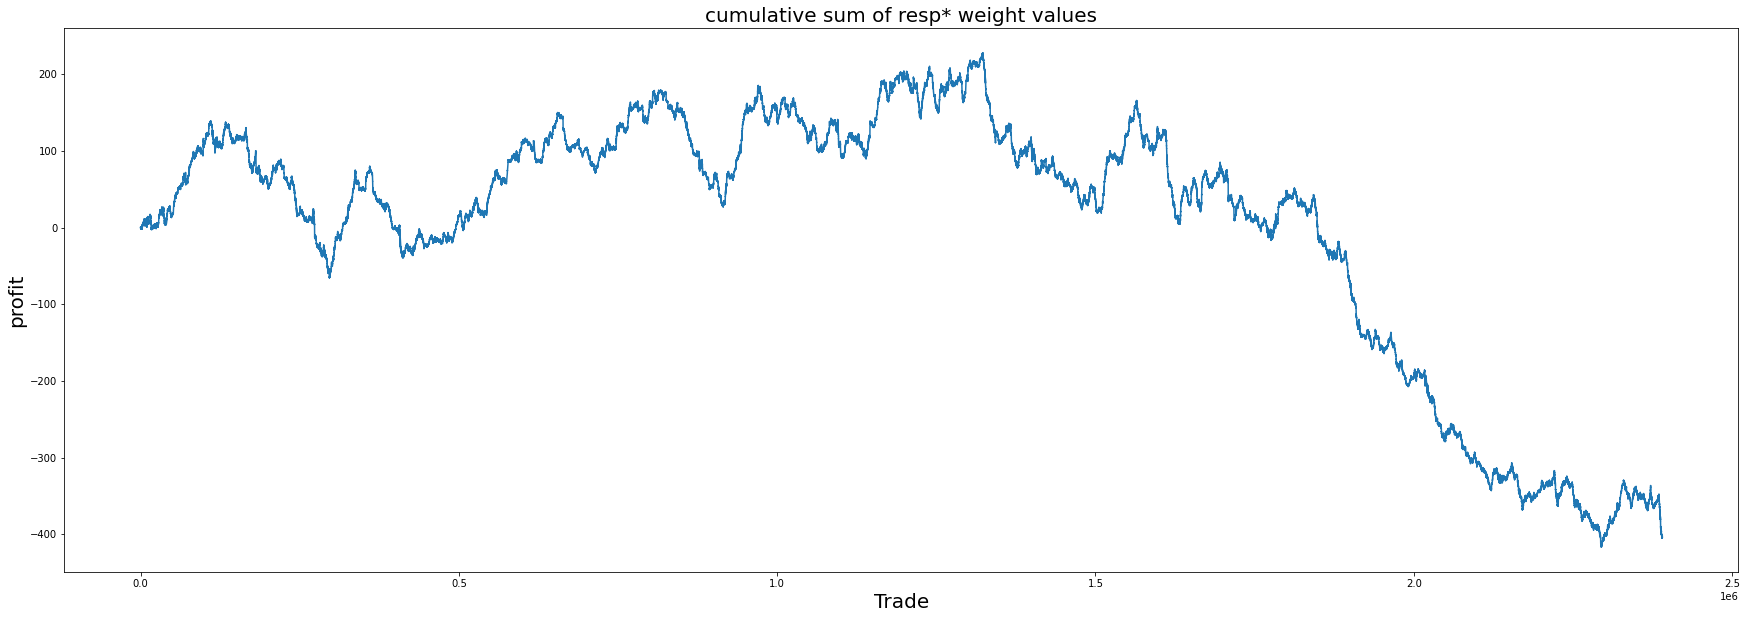

In [ ]:

plt.figure(figsize=(30,10))
plt.plot((train['resp']*train['weight']).cumsum())
plt.xlabel ("Trade",fontsize=20)
plt.ylabel ("profit",fontsize=20)
plt.title('cumulative sum of resp* weight values', fontsize=20)
plt.show()

the above graph is if all trades were taken and none were passed, hence it is very costly to misclassify, because the loss occured can be very high hence recall should be a important criteria


# Univariate analysis

Most of the features seem to be very similar and there seem to be no obvious difference between them, we might need as many columns as possible tobe able to differentiate classes

feature_0 seems interesting as there are just 2 values (+1,-1)

In [ ]:
np.unique(train['feature_0'])

array([-1,  1])

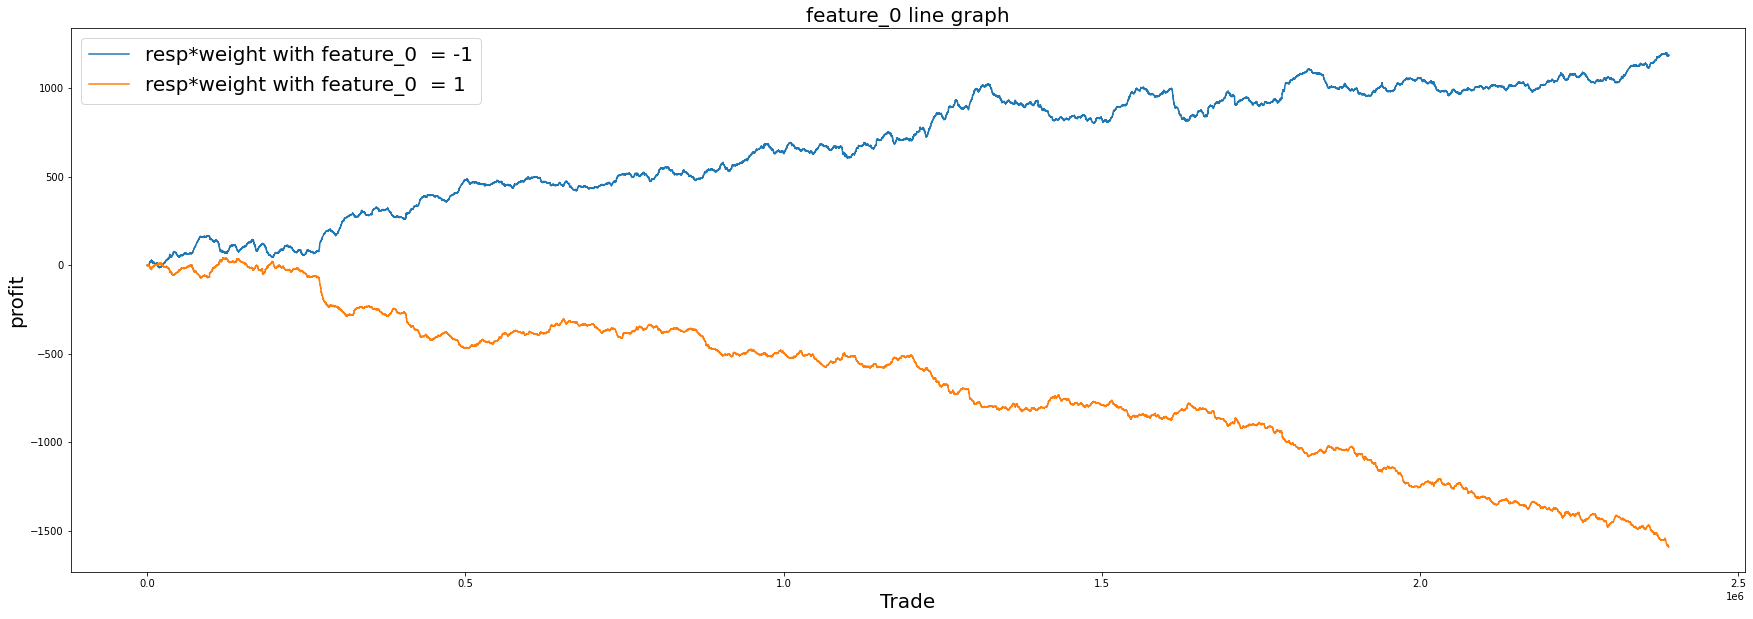

In [ ]:
plt.figure(figsize=(30,10))
plt.plot((train['resp'][train['feature_0']==-1]*train['weight'][train['feature_0']==-1]).cumsum())
plt.plot((train['resp'][train['feature_0']==1]*train['weight'][train['feature_0']==1]).cumsum())
plt.legend(('resp*weight with feature_0  = -1','resp*weight with feature_0  = 1'),fontsize=20)
plt.xlabel ("Trade",fontsize=20)
plt.ylabel ("profit",fontsize=20)
plt.title('feature_0 line graph', fontsize=20)
plt.show()

as we can see that there is clearly a trend when feature _0 = -1 the cumulative sum is returning profit and when feature_0=+1 the cumulative sum is returning loss  

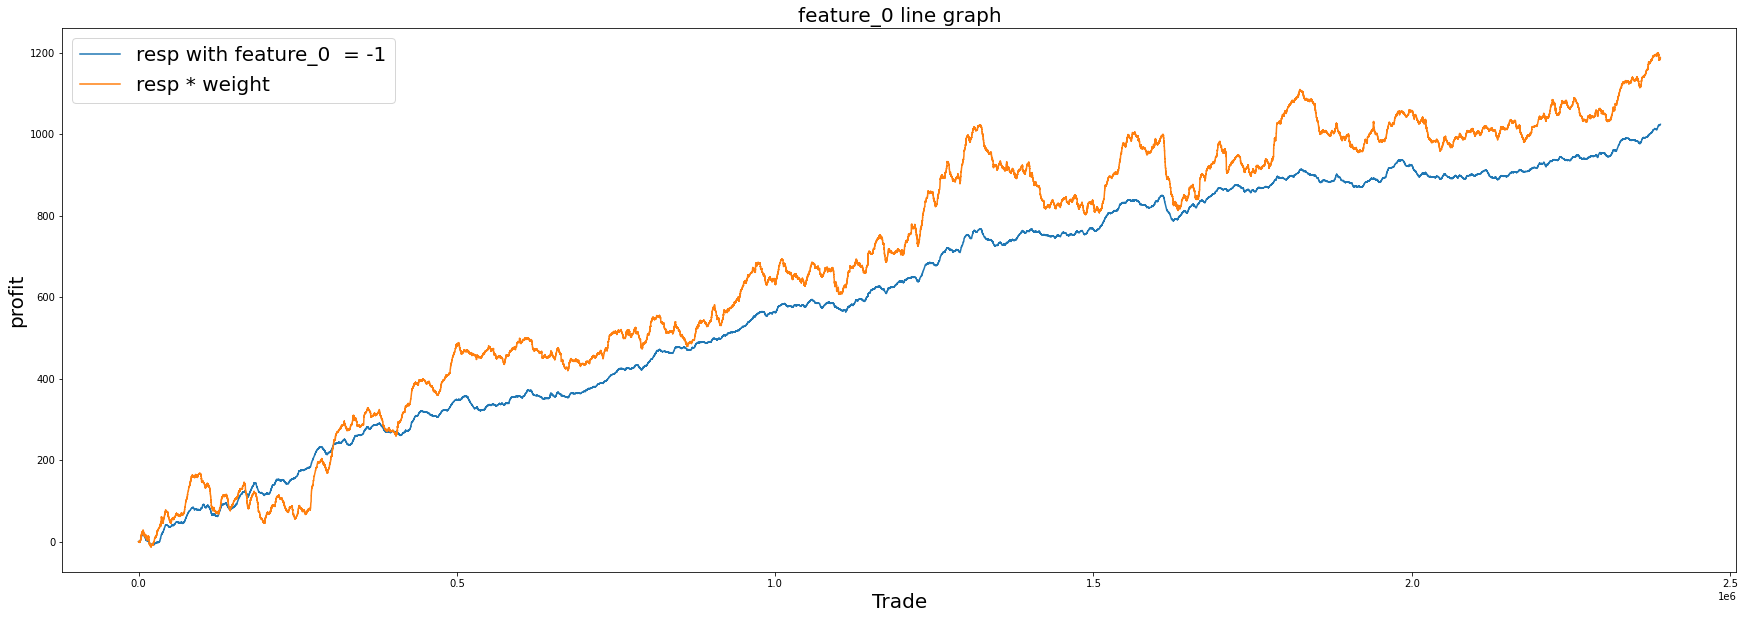

In [ ]:
plt.figure(figsize=(30,10))
plt.plot((train['resp'][train['feature_0']==-1]).cumsum())
plt.plot((train['resp'][train['feature_0']==-1]*train['weight'][train['feature_0']==-1]).cumsum())
plt.legend(('resp with feature_0  = -1','resp * weight'),fontsize=20)
plt.xlabel ("Trade",fontsize=20)
plt.ylabel ("profit",fontsize=20)
plt.title('feature_0 line graph', fontsize=20)
plt.show()

cumulative sum of resp values and the values of profit(resp*weight) have an upward trend with feature_0=-1 and with feature_0=+1 has a negative trend as  we can see in the graph below


Feature_0 seems like an important feature because of the trend showing good difference between different labels

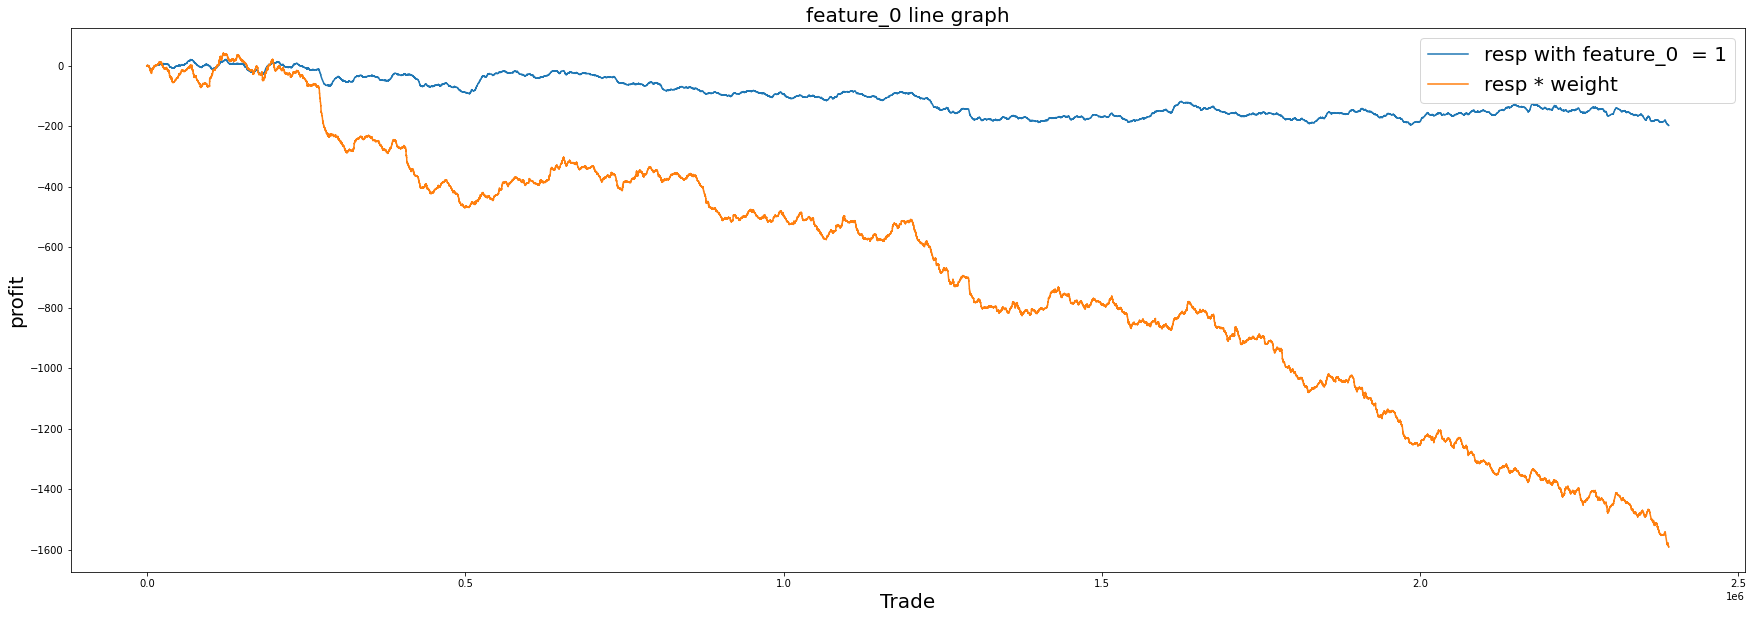

In [ ]:
plt.figure(figsize=(30,10))
plt.plot((train['resp'][train['feature_0']==1]).cumsum())
plt.plot((train['resp'][train['feature_0']==1]*train['weight'][train['feature_0']==1]).cumsum())
plt.legend(('resp with feature_0  = 1','resp * weight'),fontsize=20)
plt.xlabel ("Trade",fontsize=20)
plt.ylabel ("profit",fontsize=20)
plt.title('feature_0 line graph', fontsize=20)
plt.show()

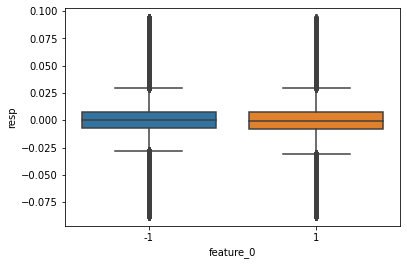

In [ ]:
sns.boxplot(x='feature_0',y='resp',data=train)
plt.show()

even after removing outliers it is very hard to differentiate these values from boxplots, they seem to have 25,50,75 percentile values at very similar range. 

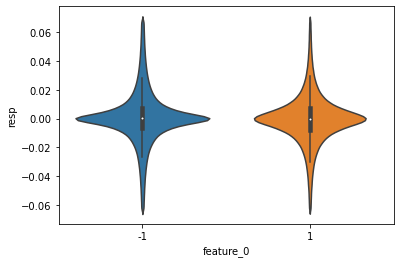

In [ ]:
sns.violinplot(x='feature_0',y='resp',data=train[(train['resp']< train['resp'].quantile(0.99)) & (train['resp']> train['resp'].quantile(0.01))])
plt.show()

we can observe that resp with feature_0 = +1 there is a little more variace compared to the other but it is not very different from the other.

In [ ]:
cols_f=[]
for i in train.columns:
  if 'feature'   in i:
    cols_f.append(i)

In [ ]:
cols=[]
for i in train.columns:
  if 'feature' not  in i:
    cols.append(i)


In [ ]:
x=train.dropna()
y=x['label']

Train test split

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(train.drop(cols,axis=1), train['label'], test_size=0.33, random_state=30)
aa=train.drop(cols,axis=1)
aa.dropna(inplace=True)
X_train = aa[:int(train.shape[0]*0.8)]
X_test = aa[int(train.shape[0]*0.8):]
y_train =  train['label'][:int(train.shape[0]*0.8)]
y_test =  train['label'][int(train.shape[0]*0.8):]


In [ ]:
del aa

Recurssive feature elimination to find top 10 features with most importance

In [ ]:
rf = RandomForestClassifier()

selector = RFE(rf, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)


In [ ]:
states = selector.support_


In [ ]:
imp_fea=list(list(np.where(states)[0]))


In [ ]:
#imp_fea=[0, 17, 20, 30, 84, 87, 95, 102, 103, 109]

In [ ]:
X_train=pd.DataFrame(X_train)
X_train['label']=y_train

In [ ]:
cols.remove('label')

In [ ]:
X_train.columns=train.drop(cols,axis=1).columns
X_train.head()

feature_0  feature_1  feature_2  ...  feature_128  feature_129  label
479          1   0.086238  -1.370409  ...     1.023031    -0.635663    1.0
480         -1   2.540471   1.213258  ...     3.322019     0.044636    0.0
483         -1  -2.425002  -2.544622  ...     0.781045     2.948364    0.0
489         -1   1.914959   0.138352  ...     0.621575    -0.071838    0.0
491          1   2.118150   0.202468  ...     2.785174    -0.366129    1.0

[5 rows x 131 columns]

In [ ]:
top_10_col=X_train.columns[imp_fea]

In [ ]:
train.head()

date     weight    resp_1    resp_2  ...  feature_128  feature_129  ts_id  label
1     0  16.673515 -0.002828 -0.003226  ...    -1.304614     1.898684      1      0
4     0   0.138531  0.001252  0.002165  ...     0.362636     3.926633      4      0
6     0   0.190575 -0.001939 -0.002301  ...     0.361506     3.921714      6      1
7     0   3.820844  0.017395  0.021361  ...     2.201537     4.429745      7      1
8     0   0.116557 -0.005460 -0.007301  ...     1.778029     4.740577      8      0

[5 rows x 139 columns]

In [ ]:
top_10_col

Index(['feature_0', 'feature_17', 'feature_20', 'feature_30', 'feature_84',
       'feature_87', 'feature_95', 'feature_102', 'feature_103',
       'feature_109'],
      dtype='object')

In [ ]:
def new_plot(fe):
  '''plots all the required graphs for univariate analysis'''
  fig, axs = plt.subplots(4, figsize=(10,40))

  axs[0].hist(train[fe],bins=1000, edgecolor='blue')
  axs[0].set_xlim(-5,5)
  axs[0].set_title(fe+' distribution')
  axs[0].set_xlabel ("bins",fontsize=20)
  axs[0].set_ylabel ("count",fontsize=20)
  
  axs[1].hist(train[fe][train['label']==0],bins=1000, edgecolor='blue')
  axs[1].hist(train[fe][train['label']==1],bins=1000,alpha=0.5)
  axs[1].set_xlim(-5,5)
  axs[1].legend((fe+' with class=0 ',fe+' with class=1'))
  axs[1].set_title(fe+'class wise distribution')
  axs[1].set_xlabel ("bins",fontsize=20)
  axs[1].set_ylabel ("count",fontsize=20)

 
  axs[2].plot((train[fe][train['label']==0]).cumsum())
  axs[2].plot((train[fe][train['label']==1]).cumsum())
  axs[2].legend(('cumulative sum of '+ fe+' with label=0','cumulative sum of '+ fe+' with label=1'),fontsize=20)
  axs[2].set_xlabel ("Time",fontsize=20)
  axs[2].set_ylabel ("cumulative _sum",fontsize=20)


  axs[3]=sns.boxplot(x='label',y=fe,data=X_train)



  c=train[fe].isnull().value_counts()[0]
  print(f'{fe} has {((train.shape[0]-c)/train.shape[0])*100}% of missing values')

  plt.show()

feature_17

feature_17 has 15.817848738786019% of missing values


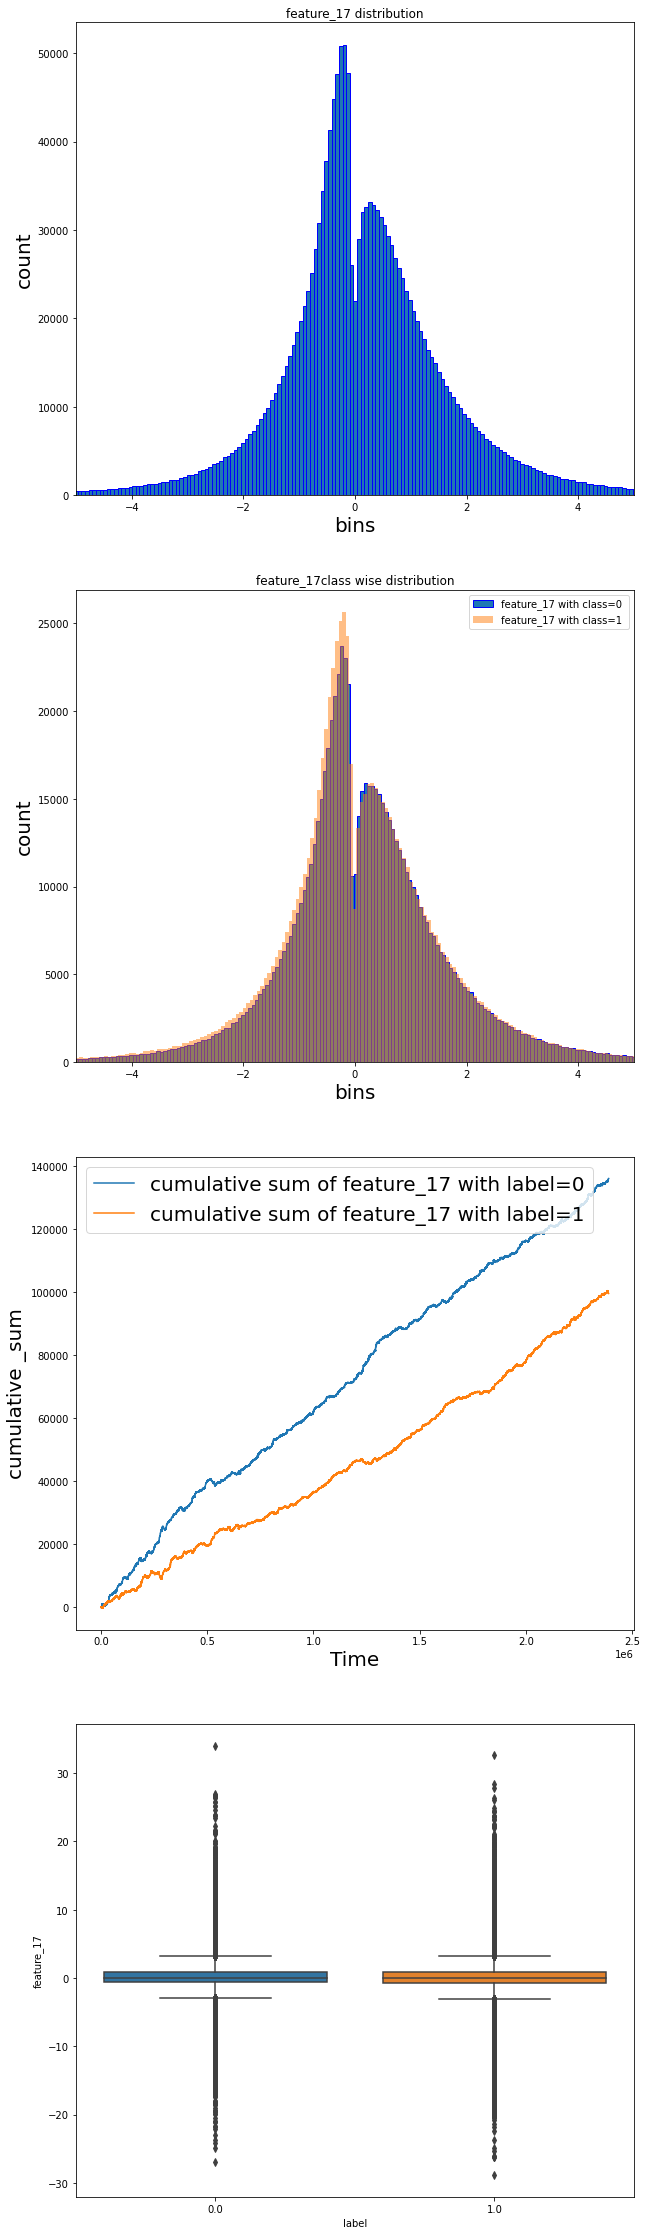

In [ ]:
new_plot('feature_17')

Feature_17 pdf seems very similar to gaussian except at a 0 were the number of values are significantly less compared to other parts, this feature is almost indistinguisable from each of the labels.The CDF distriution reveals that the values of feature with label=1 have lower values in general. The boxplot also shows almost similar results for both the labels, but there are other features which have distribution similar to the PDF of this feature, these features seem to originate from same source with different time horizons.

Feature_20

feature_20 has 0.029459313443489878% of missing values


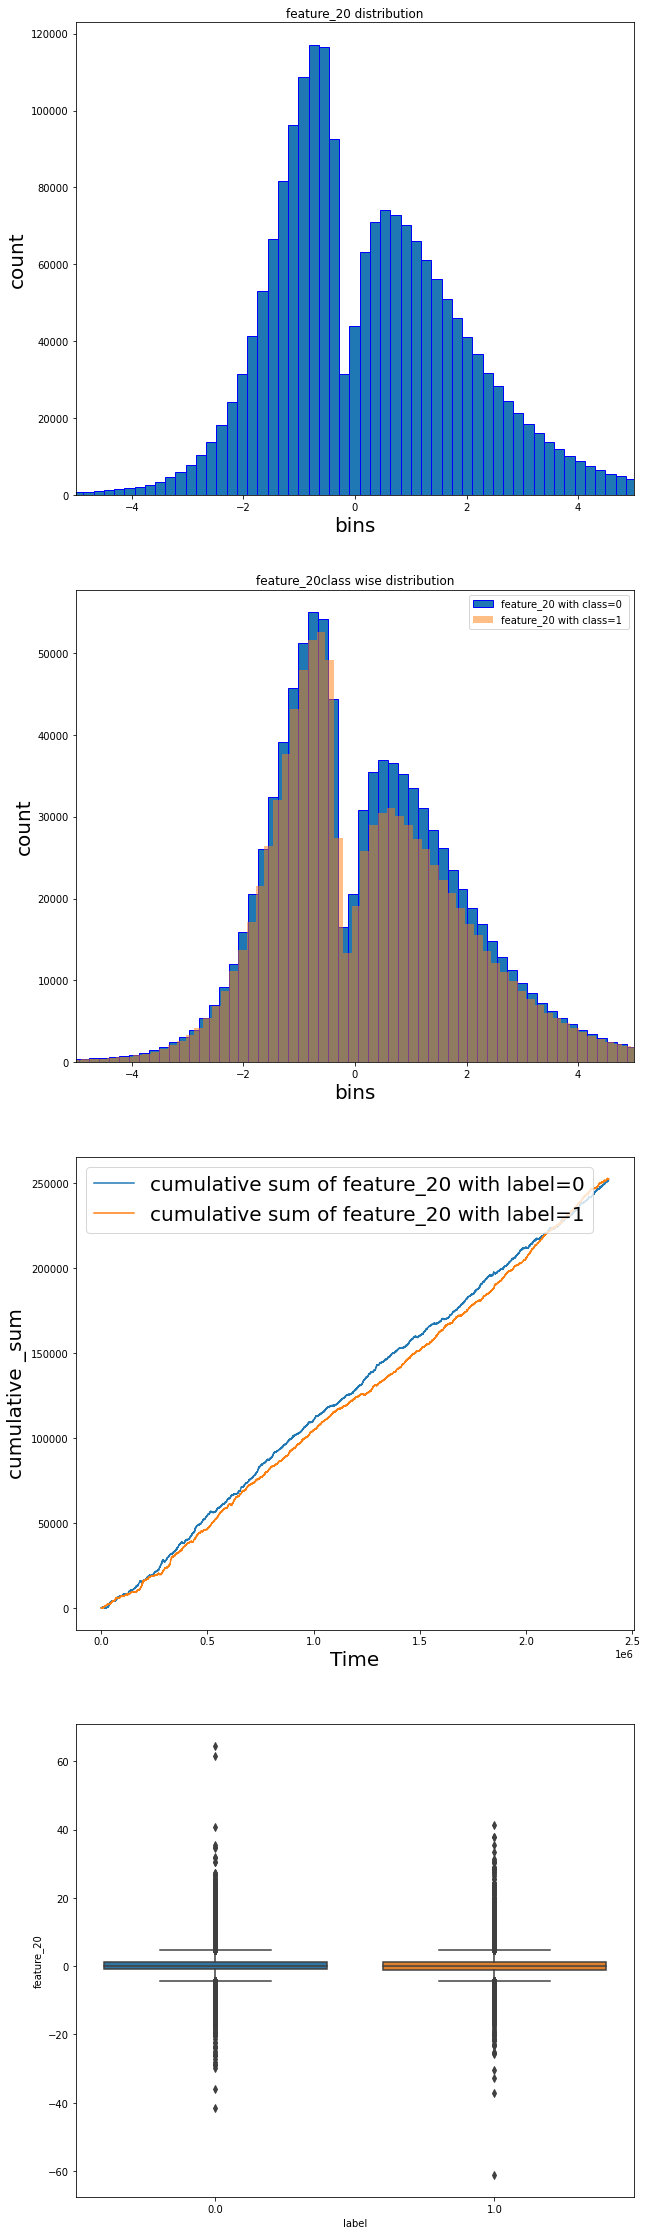

In [ ]:
new_plot('feature_20')

this is a similar type of distribution as we had in feature_17 but here the distribution is much more spread as we can observe larger bins in the pdf graph of this feature. we can also observe in class wise distribution that classes are not distiniguishable. even the case is same with boxplot. In the CDF of this feature both the graphs seem very similar and there seem to be no obvious trend seperating them

Feature_30

feature_30 has 0.029459313443489878% of missing values


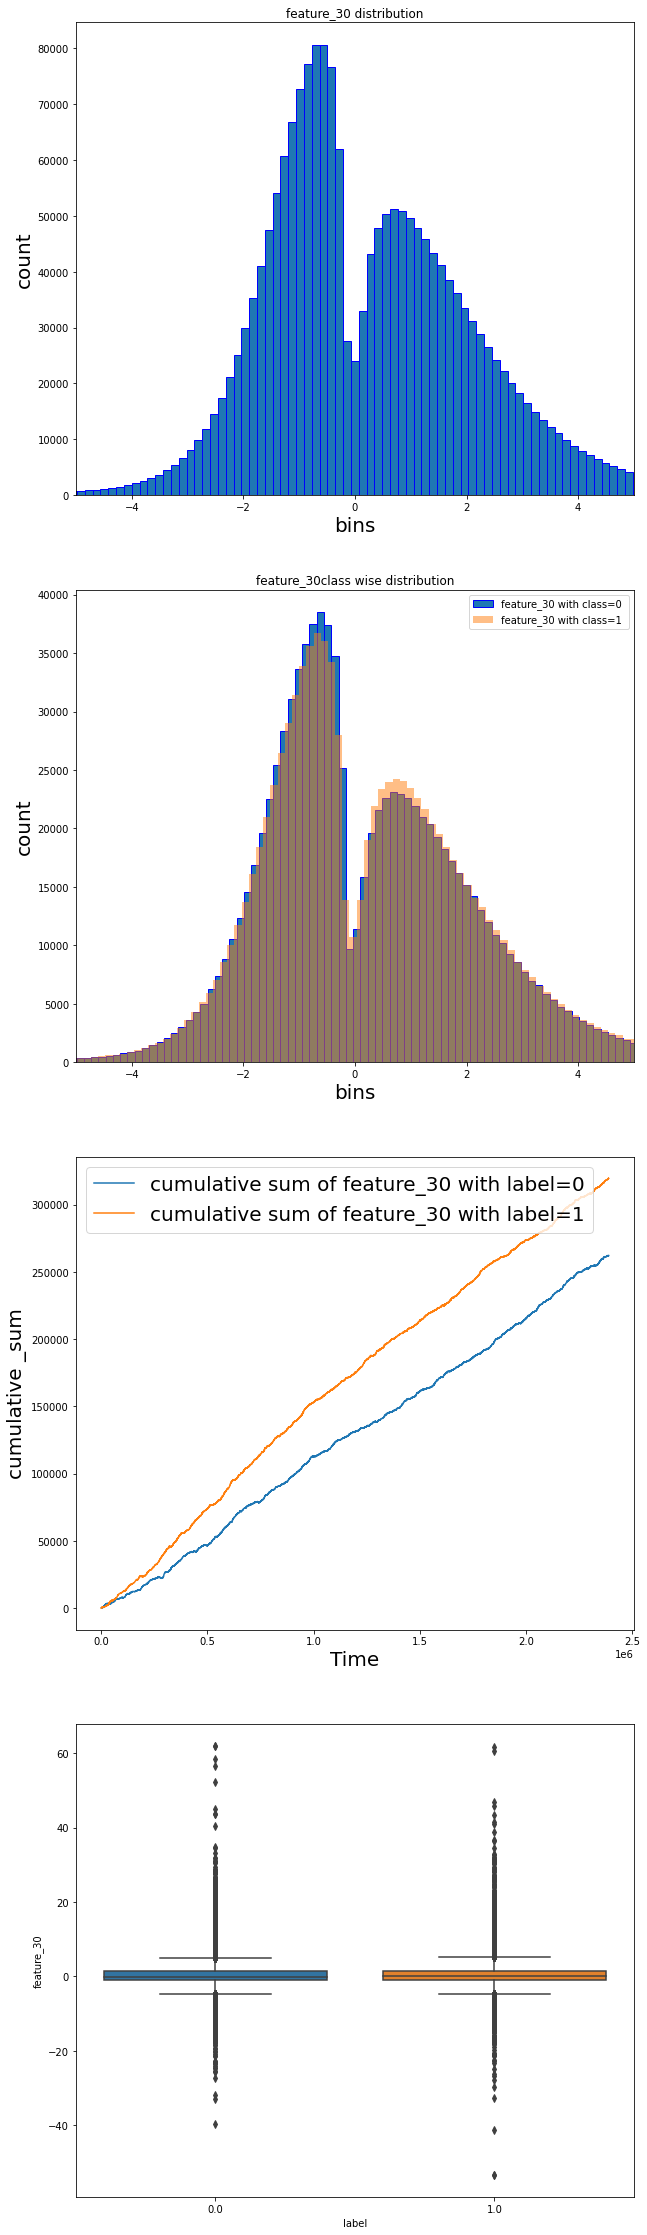

In [ ]:
new_plot('feature_30')

this feature also has a similar trend as the above 2 and these features might be of different time horizons

feature_84

feature_84 has 14.118993995347282% of missing values


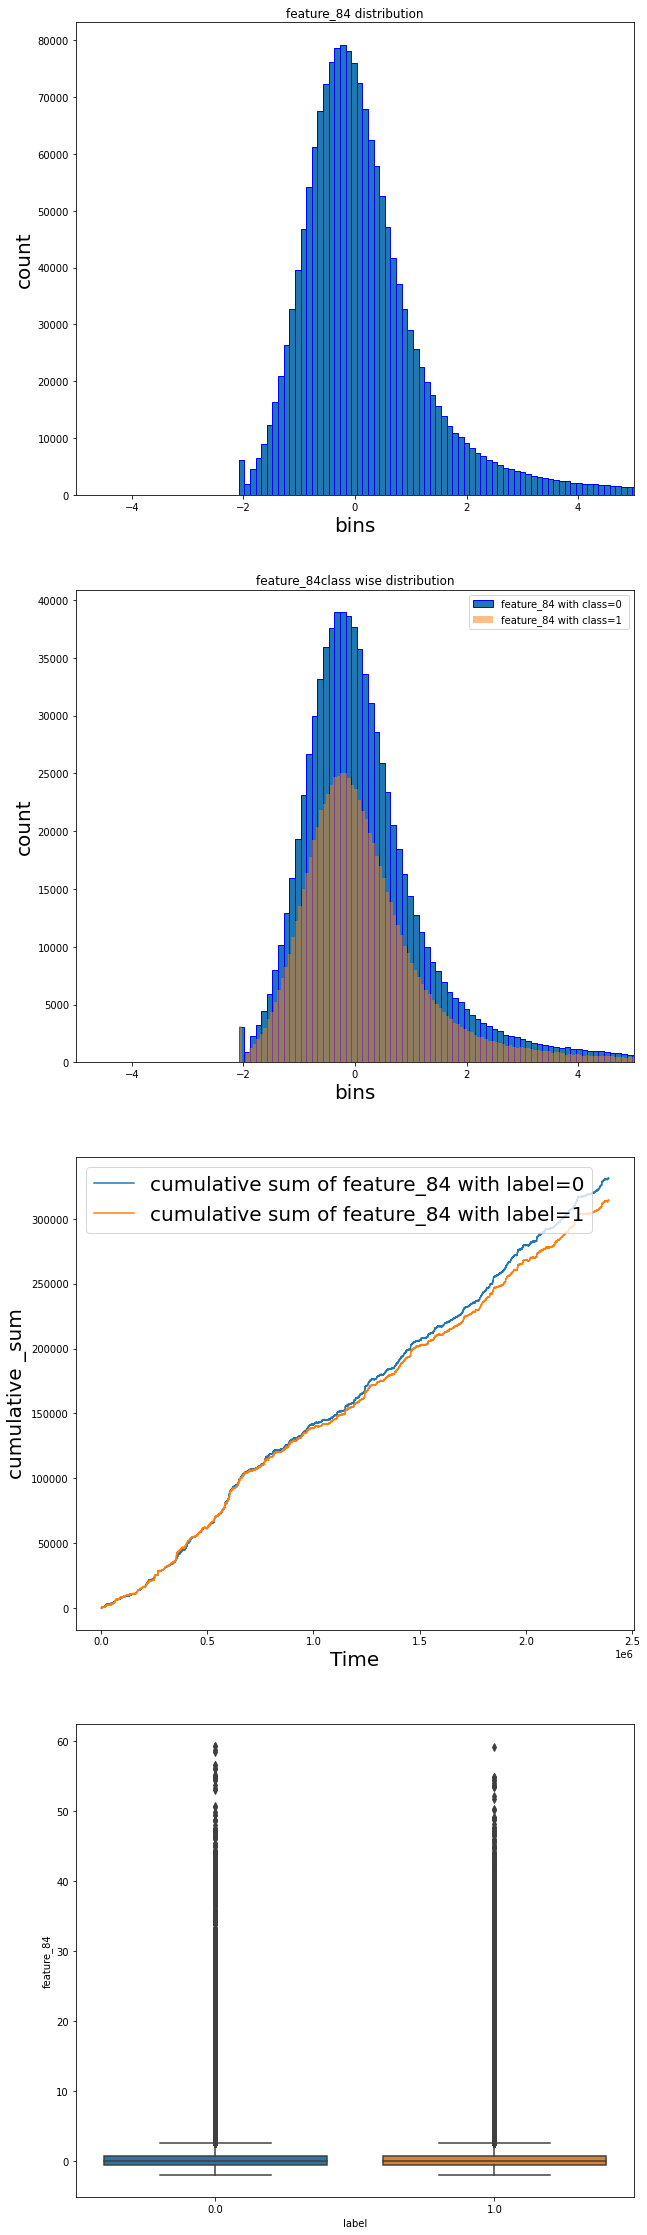

In [ ]:
new_plot('feature_84')

This feature has a very long tail in the positive direction,there is no class wise differentiotion which can be found in the class wise PDF. the CDF and PDF are also very closeto each other this feature was selected in forward feature selection hence this feature might have a good significance with other features combined

feqature_87

feature_87 has 0.5782677820690635% of missing values


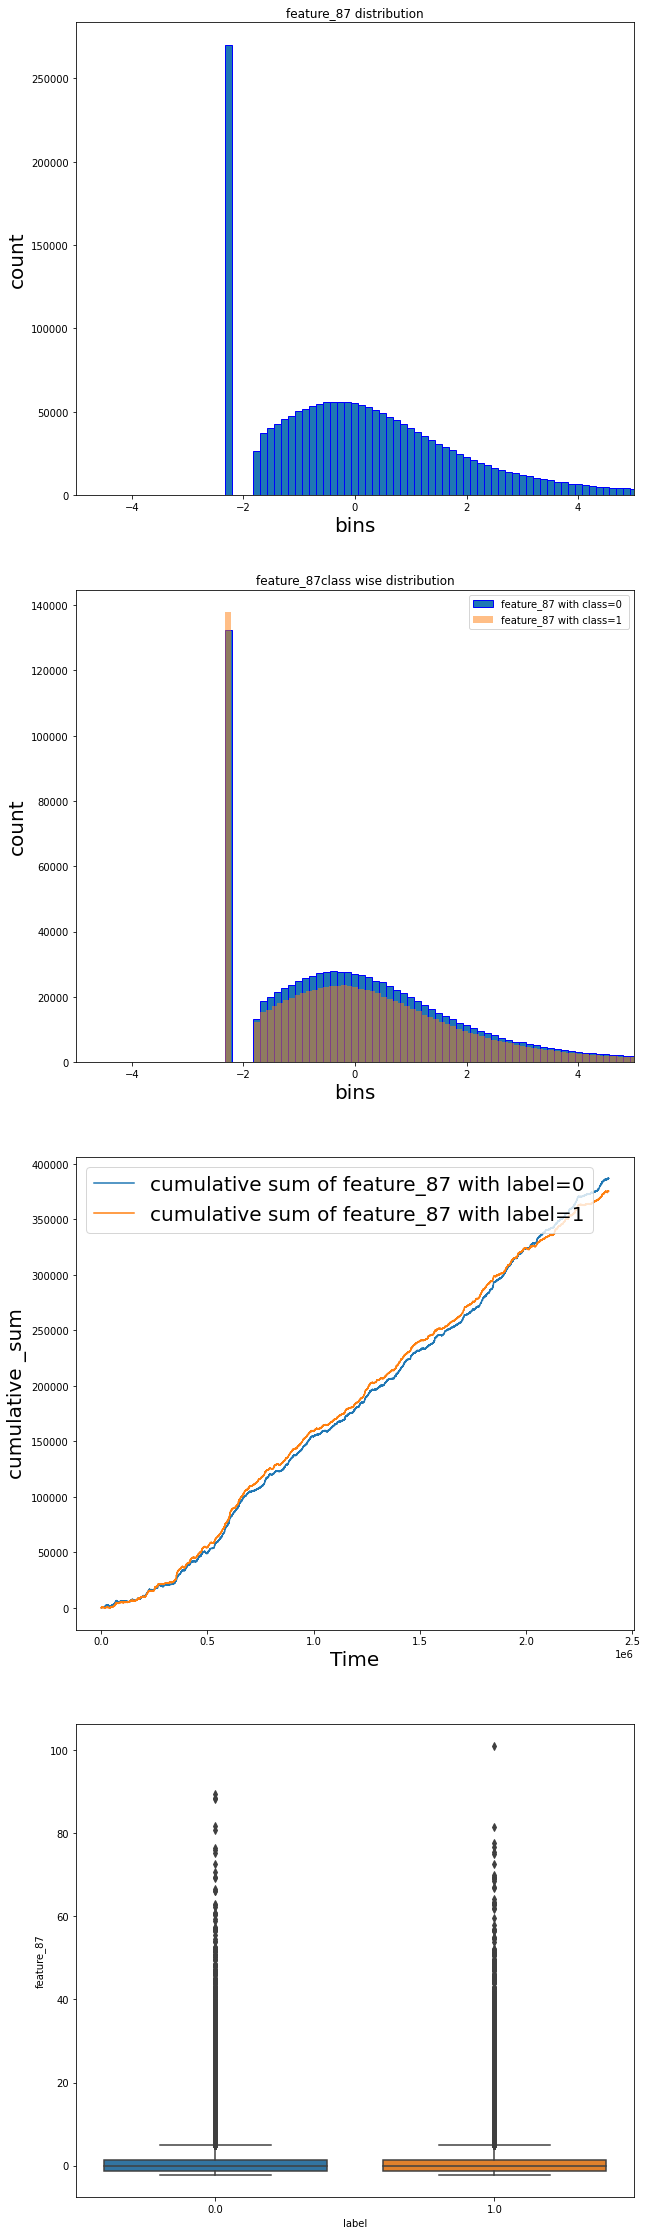

In [ ]:
new_plot('feature_87')

This feature is quite different from others as we can see from the PDF, there are a very good chunk of points which have the same value  but that still is not helping to differentiate classes. The CDF is also very similar to both the labels

feature_95

feature_95 has 0.0% of missing values


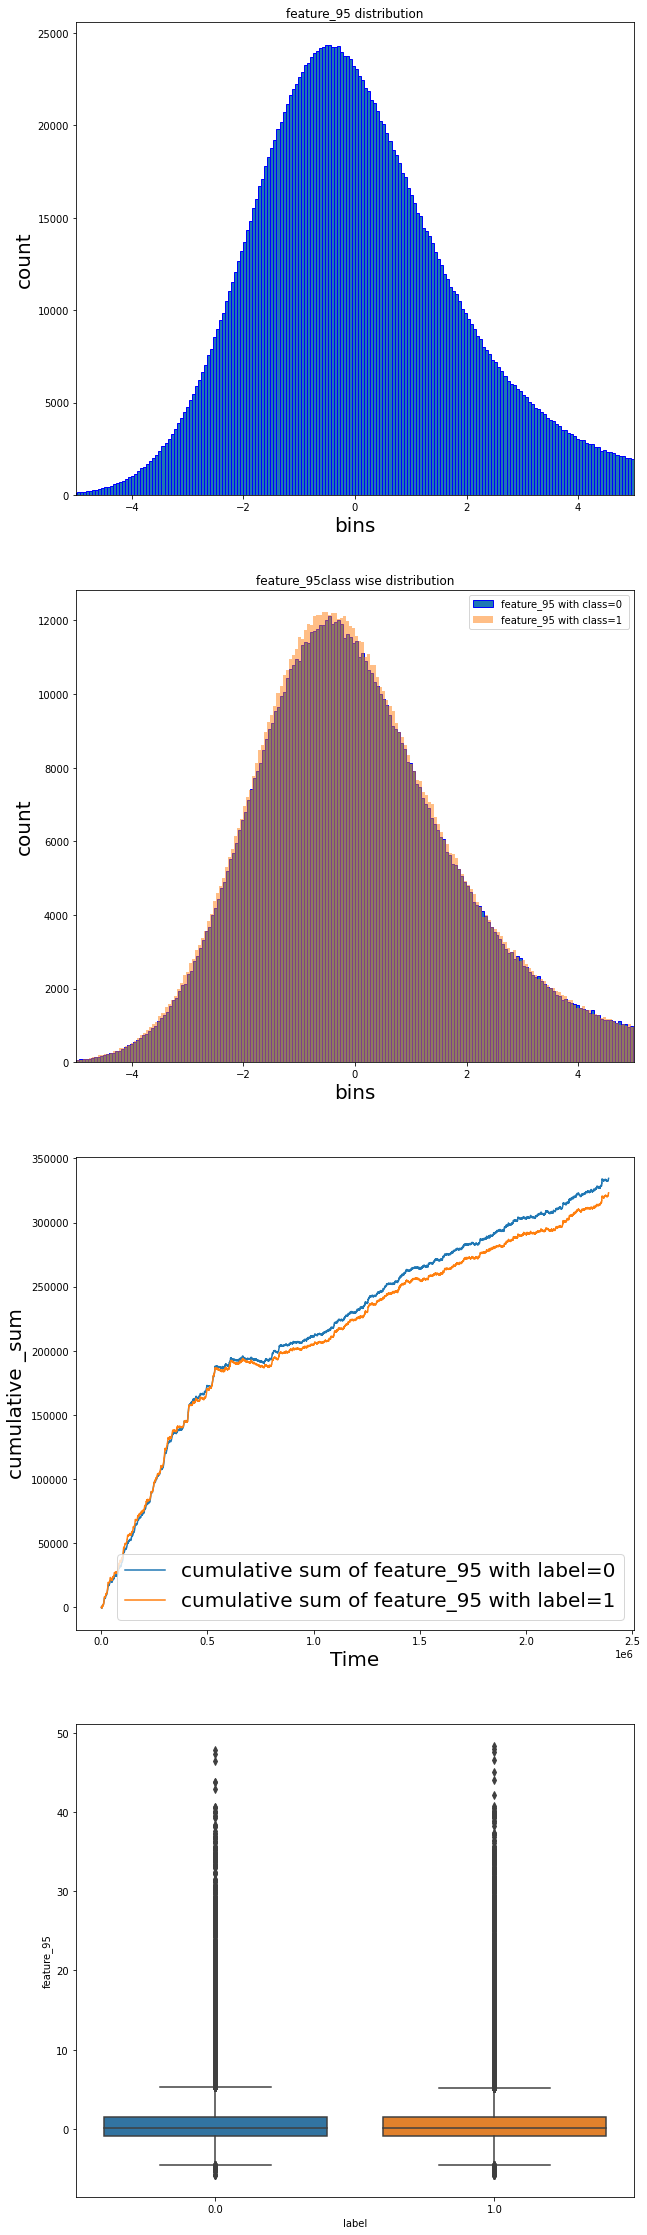

In [ ]:
new_plot('feature_95')

THis feature looks similar to gaussian but is not as we can observe a fatter tail in positive direction. this feature also has different type of distribution compared to others we have observed

feature_102

feature_102 has 14.118993995347282% of missing values


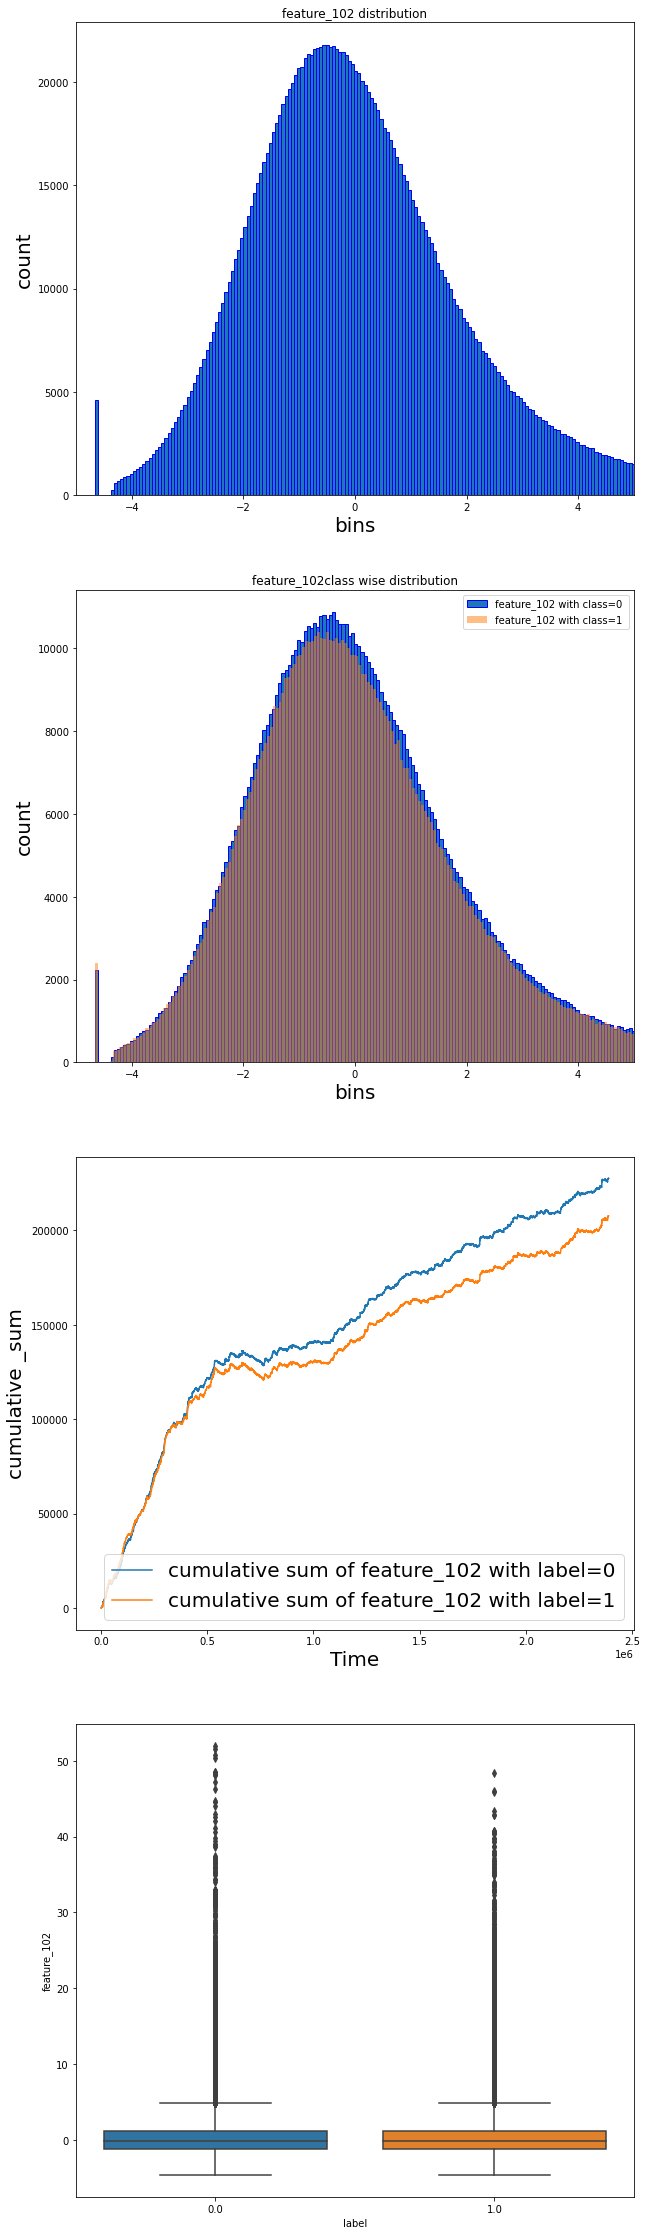

In [ ]:
new_plot('feature_102')

Feature 95 and 102 have similar distribution but they might be from different time horizons. but we can see that there are considerable amount of same values close to -5 , which is a similar trend as feature 109

feature_103

feature_103 has 0.029459313443489878% of missing values


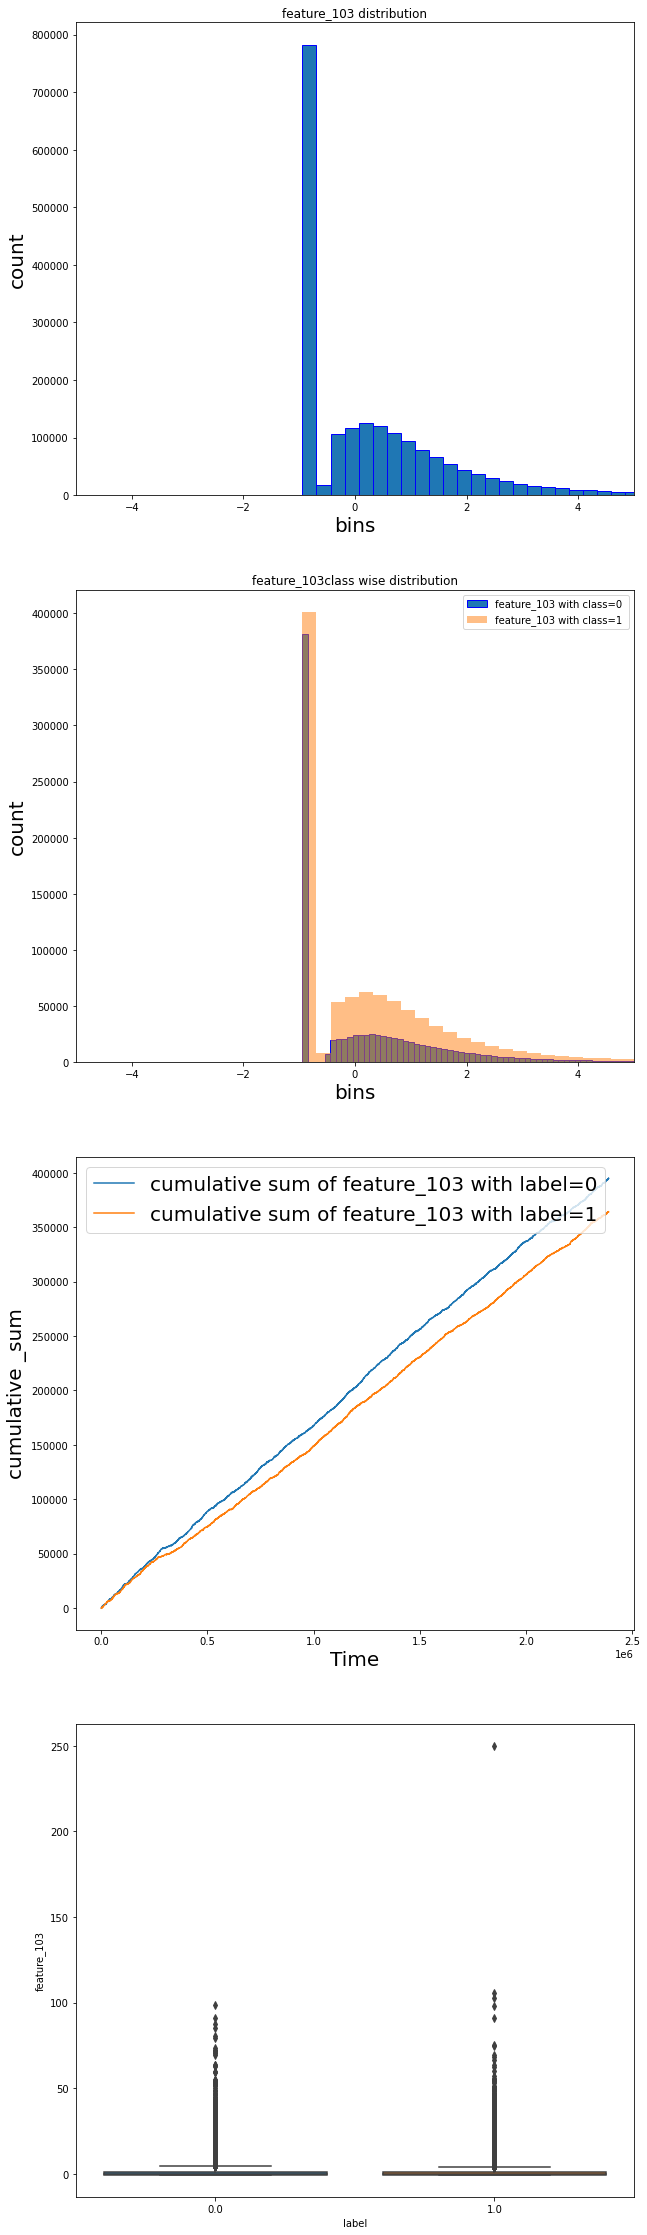

In [ ]:
new_plot('feature_103')

feature_109

feature_109 has 0.029459313443489878% of missing values


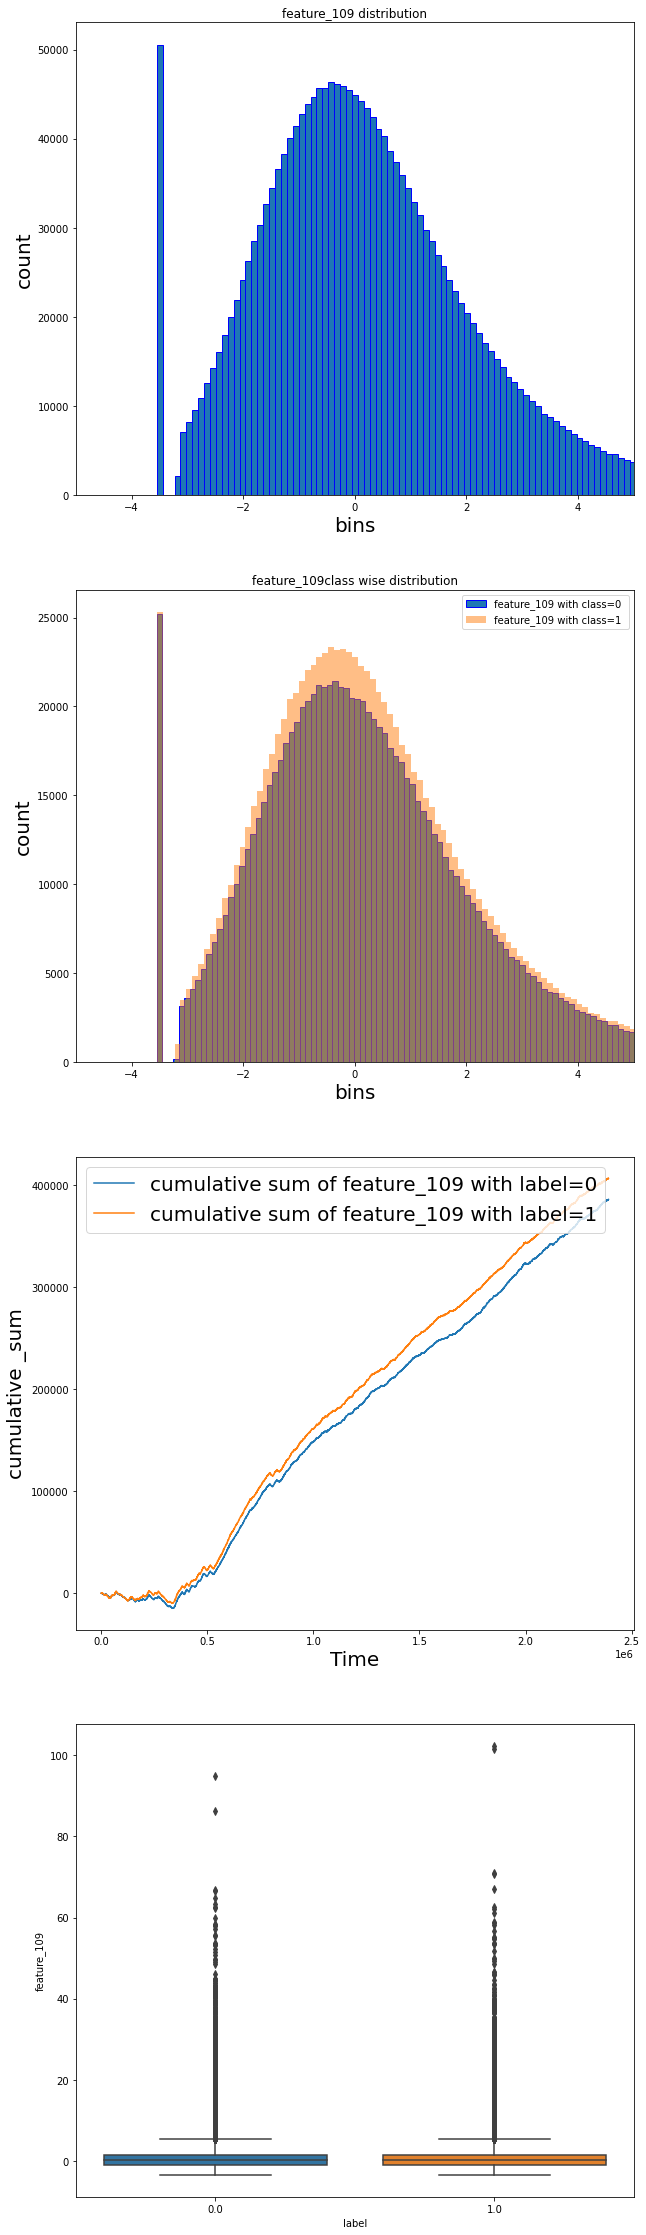

In [ ]:
new_plot('feature_109')

Feature 109 is similar to above 2 but here we have a very large number of values near -4 and this trend seem to be increasing. but we donot know if it is increasing as time horizon is decreasing or when it is increasing as the features are anonamized.

# pair plot


In [ ]:
top_10_col=list(top_10_col)
top_10_col.append('label')

In [ ]:
train[top_10_col]

feature_0  feature_17  feature_20  ...  feature_103  feature_109  label
1               -1         NaN   -0.625682  ...     0.949879    -1.332492      0
4                1         NaN    2.484082  ...     0.762192    -0.934675      0
6               -1         NaN   -4.144813  ...     1.282053    -0.076840      1
7               -1         NaN   -1.997592  ...    -0.940190    -1.949191      1
8                1         NaN   -0.056330  ...    -0.940190    -2.416447      0
...            ...         ...         ...  ...          ...          ...    ...
2390444         -1   -1.000122   -0.751865  ...    -0.940190    -1.252670      0
2390446          1    2.511355    2.081128  ...     0.850131     0.681588      0
2390478         -1   -0.654052   -1.023189  ...    -0.019747     1.587147      0
2390481         -1   -0.263636   -1.310911  ...    -0.940190     1.326799      0
2390489         -1   -0.968833   -3.246740  ...     9.192617     1.006577      0

[1941661 rows x 11 columns]

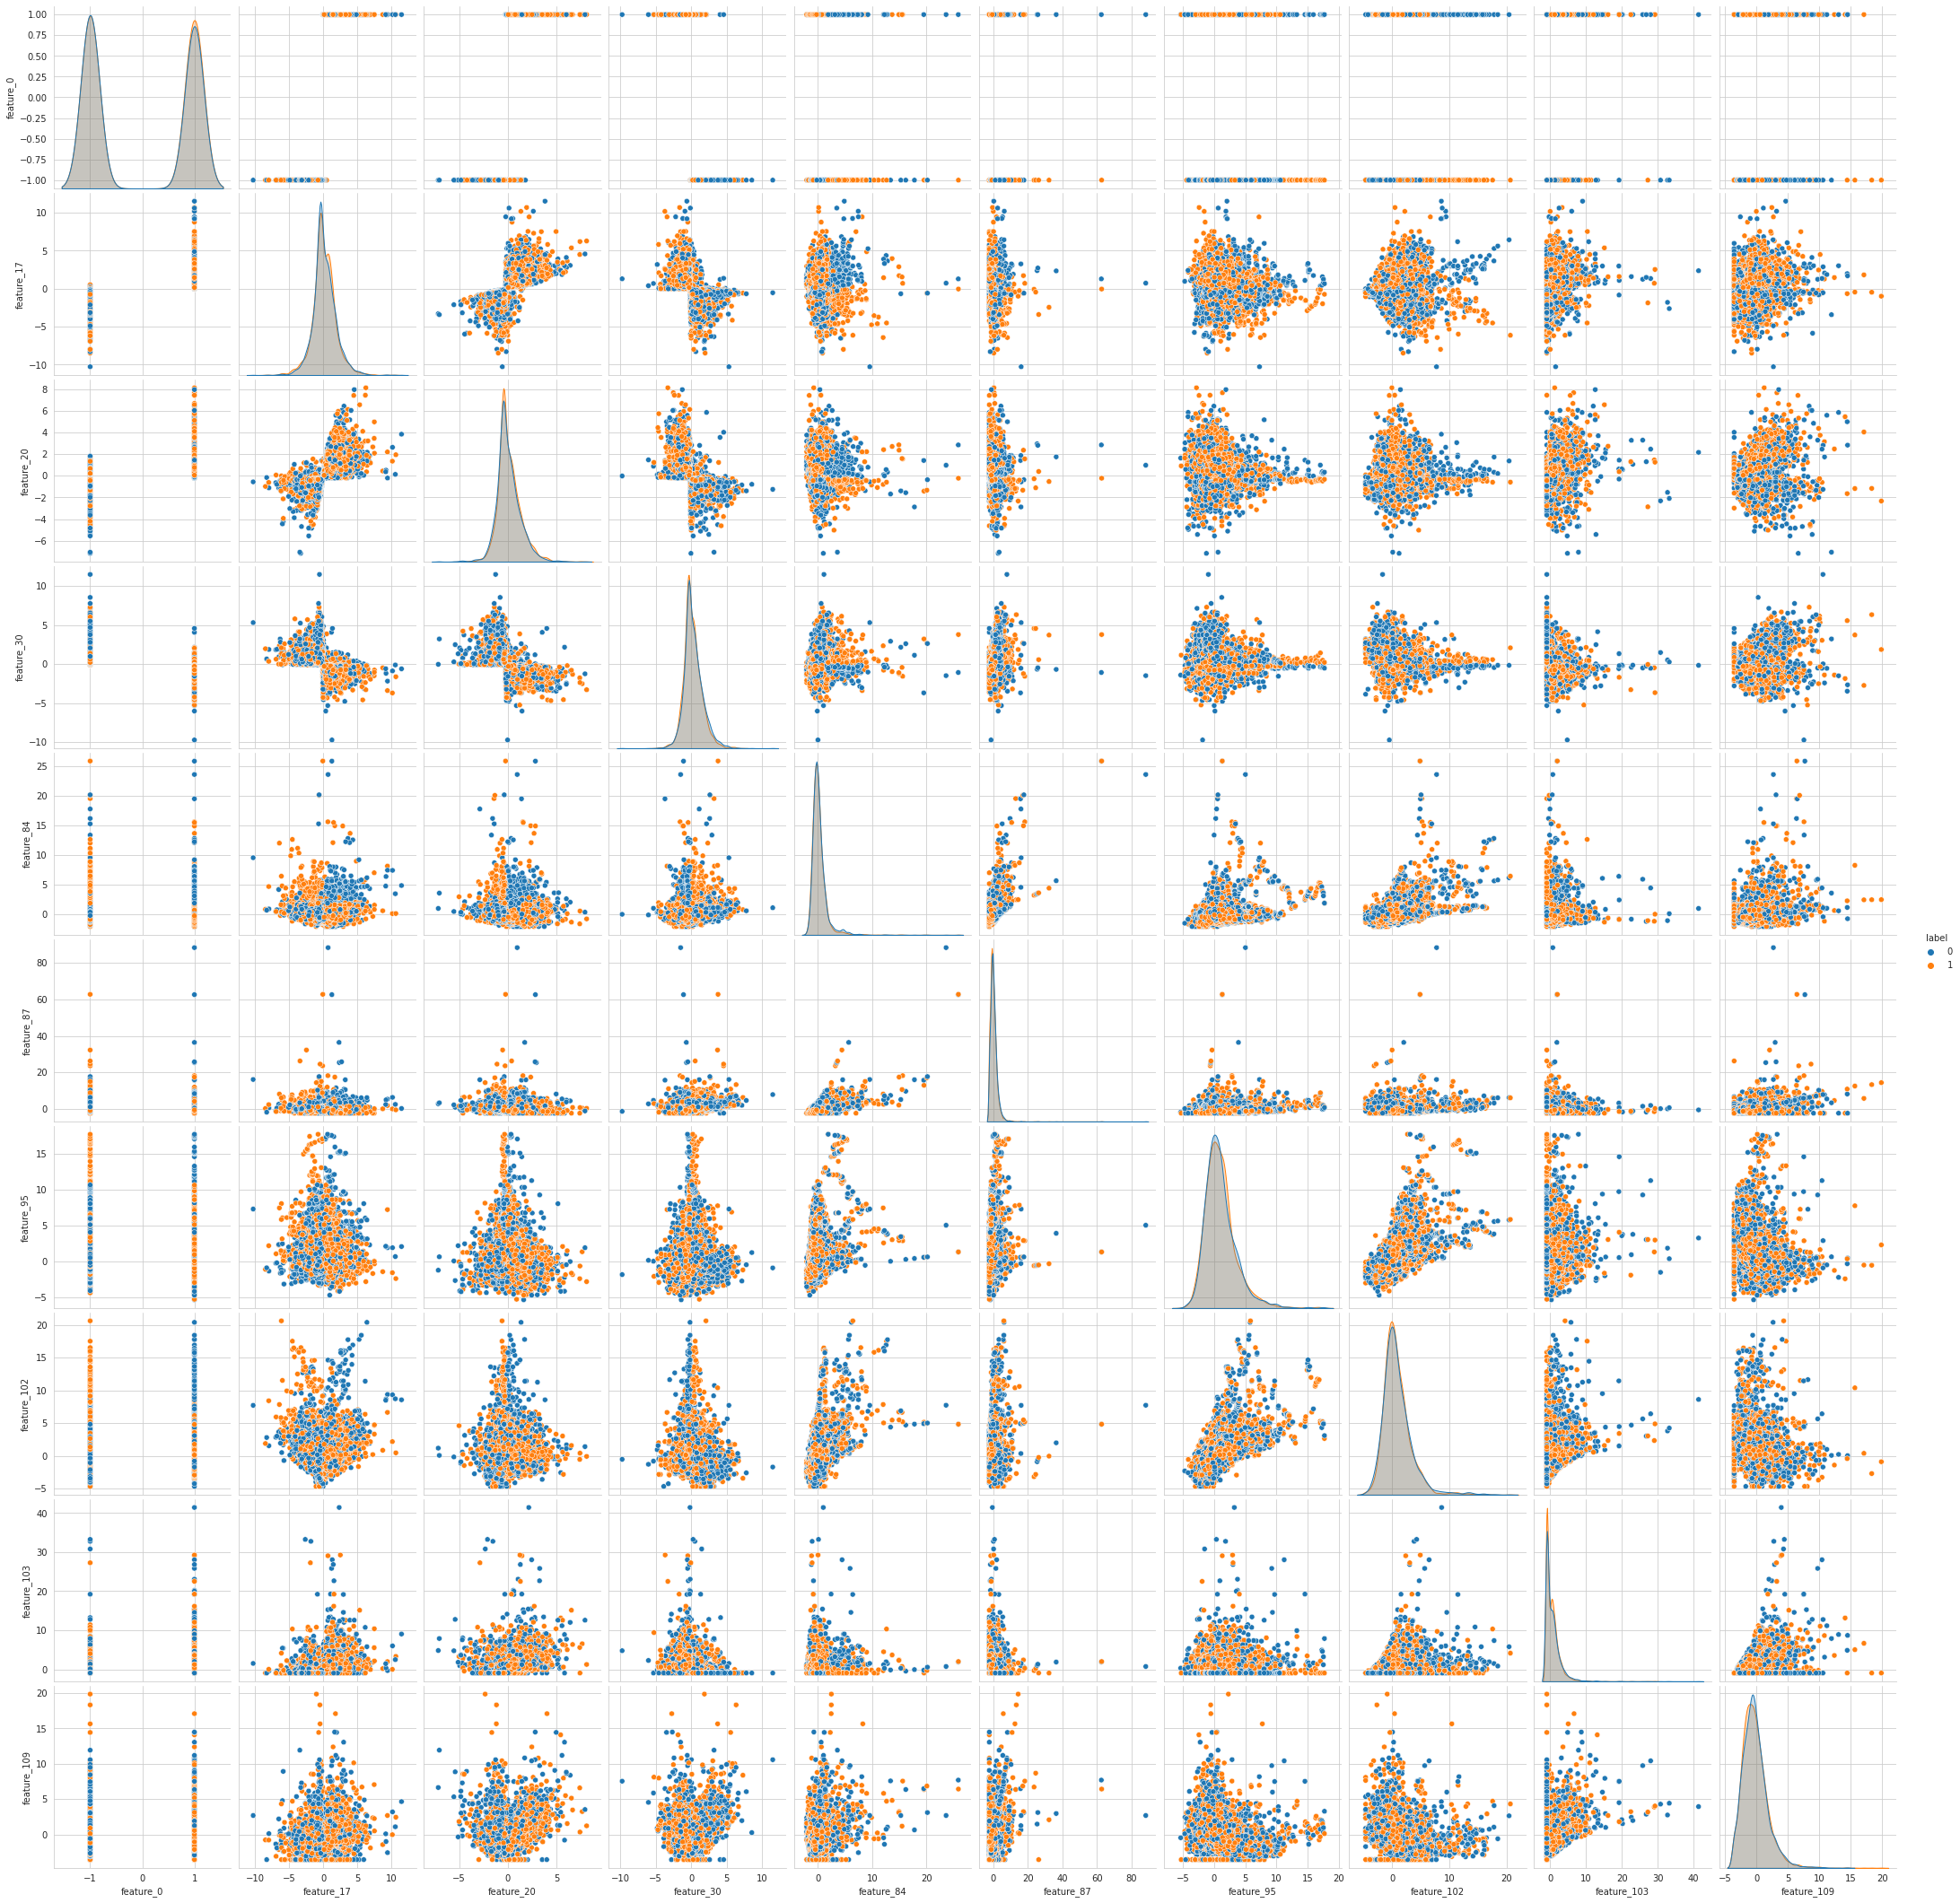

In [ ]:
sns.set_style("whitegrid");
sns.pairplot(train[top_10_col][0:10000], hue="label", height=3);
plt.show()

we still can't find a clear difference between classes in all of the above pair plots as they seem to be completely jumbled in most of the cases but we still can see some minor clustering in some features. most clustering is found to the plots related to feature 84

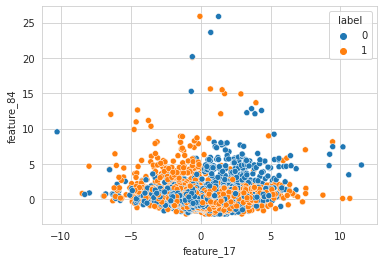

In [ ]:
sns.scatterplot(data=train[0:10000], x="feature_17", y="feature_84",hue='label')
plt.show()

we can see that feature 17 and 84 seem to have a good clustering in different points of the graph but it is still better than most features. 

In [ ]:
fig = px.scatter_3d(train[0:2000], x='feature_17', y='feature_84', z='feature_102',
              color='label')
fig.show()  

here also we can see some good clustering between features 84,102 and 17, the dataset is not very easy to understand using less number of features, here we will be needing as many columns as possible to get the best results

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



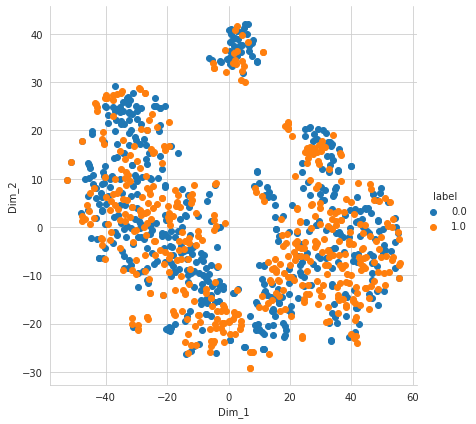

In [ ]:
# TSNE

from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
data_1000 = x[cols_f][0:1000]
labels_1000 = np.array(x['label'][0:1000])

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(data_1000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

good amount of small number of clusters can be found but we cannot seperate them using a line, hence simple regression based models may not be an ideal choice.

#Missing value imputation

all the columns have missing values less than 15% 

In [ ]:
for fe in cols_f:
  c=train[fe].isnull().value_counts()[0]
  print(f'{fe} has {((train.shape[0]-c)/train.shape[0])*100}% of missing values')

feature_0 has 0.0% of missing values
feature_1 has 0.0% of missing values
feature_2 has 0.0% of missing values
feature_3 has 0.01931336108620403% of missing values
feature_4 has 0.01931336108620403% of missing values
feature_5 has 0.0% of missing values
feature_6 has 0.0% of missing values
feature_7 has 15.727513711198815% of missing values
feature_8 has 15.727513711198815% of missing values
feature_9 has 0.029459313443489878% of missing values
feature_10 has 0.029459313443489878% of missing values
feature_11 has 3.122584220417467% of missing values
feature_12 has 3.122584220417467% of missing values
feature_13 has 0.5782677820690635% of missing values
feature_14 has 0.5782677820690635% of missing values
feature_15 has 0.25612091915118035% of missing values
feature_16 has 0.25612091915118035% of missing values
feature_17 has 15.817848738786019% of missing values
feature_18 has 15.817848738786019% of missing values
feature_19 has 0.029459313443489878% of missing values
feature_20 has 0.

All the missing values have been imputed using day wise mean for day wise missing values

In [ ]:
import warnings
warnings.filterwarnings("ignore")
for k in tqdm(cols_f):
  fill=train.groupby('date').mean()[k]
  new=[]
  for i in range(500):
    a=train[k][train['date']==i].fillna(fill.iloc[i])
    new.extend(a)
  train[k]=new


100%|██████████| 130/130 [09:40<00:00,  4.47s/it]


In [ ]:
for fe in cols_f:
  c=train[fe].isnull().value_counts()[0]
  print(f'{fe} has {((train.shape[0]-c)/train.shape[0])*100}% of missing values')

feature_0 has 0.0% of missing values
feature_1 has 0.0% of missing values
feature_2 has 0.0% of missing values
feature_3 has 0.0% of missing values
feature_4 has 0.0% of missing values
feature_5 has 0.0% of missing values
feature_6 has 0.0% of missing values
feature_7 has 0.0% of missing values
feature_8 has 0.0% of missing values
feature_9 has 0.0% of missing values
feature_10 has 0.0% of missing values
feature_11 has 0.0% of missing values
feature_12 has 0.0% of missing values
feature_13 has 0.0% of missing values
feature_14 has 0.0% of missing values
feature_15 has 0.0% of missing values
feature_16 has 0.0% of missing values
feature_17 has 0.0% of missing values
feature_18 has 0.0% of missing values
feature_19 has 0.0% of missing values
feature_20 has 0.0% of missing values
feature_21 has 0.0% of missing values
feature_22 has 0.0% of missing values
feature_23 has 0.0% of missing values
feature_24 has 0.0% of missing values
feature_25 has 0.0% of missing values
feature_26 has 0.0% of

In [ ]:
aa=train.drop(cols,axis=1)
aa.dropna(inplace=True)
X_train = aa[:int(train.shape[0]*0.8)]
X_test = aa[int(train.shape[0]*0.8):]
y_train =  train['label'][:int(train.shape[0]*0.8)]
y_test =  train['label'][int(train.shape[0]*0.8):]
del aa

# feature engineering

1. all the features are ananonamized hence autoencoder has been used to engineer 15 new features and join them to the Dattaset

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
x_train=scaler.transform(X_train)
x_test=scaler.transform(X_test)

In [ ]:
# code snippet from https://blog.keras.io/building-autoencoders-in-keras.html
input = tf.keras.Input(shape=(130,))
encoded = Dense(75, activation='relu')(input)
encoded = Dense(37, activation='relu')(encoded)
encoded = Dense(15, activation='relu')(encoded)

decoded = Dense(37, activation='relu')(encoded)
decoded = Dense(75, activation='relu')(decoded)
decoded = Dense(130, activation='relu')(decoded)

autoencoder = Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130)]             0         
_________________________________________________________________
dense (Dense)                (None, 75)                9825      
_________________________________________________________________
dense_1 (Dense)              (None, 37)                2812      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                570       
_________________________________________________________________
dense_3 (Dense)              (None, 37)                592       
_________________________________________________________________
dense_4 (Dense)              (None, 75)                2850      
_________________________________________________________________
dense_5 (Dense)              (None, 130)               9880  

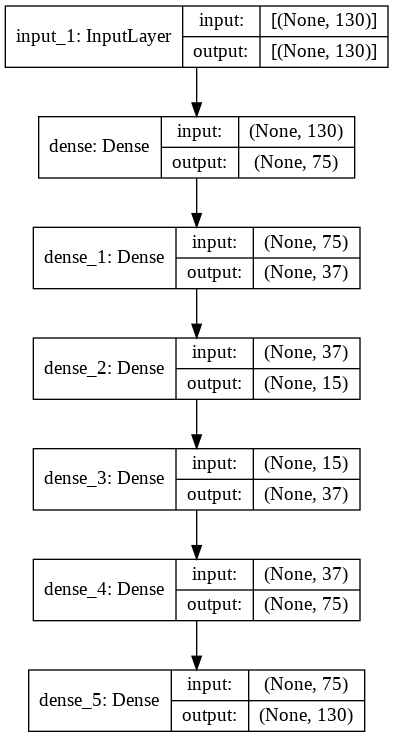

In [ ]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

In [ ]:
autoencoder.fit(x_train,x_train,epochs=100,batch_size=100000,shuffle=True,validation_data=(x_test, x_test))

Epoch 1/100
16/16 [==============================] - 8s 396ms/step - loss: 0.1052 - val_loss: 0.0673
Epoch 2/100
16/16 [==============================] - 5s 319ms/step - loss: 0.0637 - val_loss: 0.0583
Epoch 3/100
16/16 [==============================] - 5s 317ms/step - loss: 0.0582 - val_loss: 0.0578
Epoch 4/100
16/16 [==============================] - 5s 316ms/step - loss: 0.0579 - val_loss: 0.0575
Epoch 5/100
16/16 [==============================] - 5s 317ms/step - loss: 0.0577 - val_loss: 0.0575
Epoch 6/100
16/16 [==============================] - 5s 316ms/step - loss: 0.0574 - val_loss: 0.0556
Epoch 7/100
16/16 [==============================] - 5s 317ms/step - loss: 0.0556 - val_loss: 0.0537
Epoch 8/100
16/16 [==============================] - 5s 315ms/step - loss: 0.0529 - val_loss: 0.0512
Epoch 9/100
16/16 [==============================] - 5s 316ms/step - loss: 0.0514 - val_loss: 0.0510
Epoch 10/100
16/16 [==============================] - 5s 315ms/step - loss: 0.0512 - val_lo

In [ ]:
new_f = Model(input, encoded)

In [ ]:
new=new_f.predict(x_train)

In [ ]:
x_train=pd.DataFrame(x_train)

In [ ]:
x_test=pd.DataFrame(x_test)


In [ ]:
for i in range(15):
  x_train['feature_' + str(130+i)]=new[:,i]

In [ ]:
x_train.head()

0         1         2  ...  feature_142  feature_143  feature_144
0  0.0  0.023485  0.009185  ...     0.205814     1.282868          0.0
1  1.0  0.000000  0.000000  ...     0.201939     1.218181          0.0
2  0.0  0.000000  0.000000  ...     0.190259     1.260529          0.0
3  0.0  0.046624  0.017378  ...     0.322393     1.296070          0.0
4  1.0  0.000000  0.000000  ...     0.207027     1.192945          0.0

[5 rows x 145 columns]

In [ ]:
new=new_f.predict(x_test)
for i in range(15):
  x_test['feature_' + str(130+i)]=new[:,i]
x_test.head()

0         1         2  ...  feature_142  feature_143  feature_144
0  0.0  0.052446  0.020874  ...     0.315047     1.265237          0.0
1  1.0  0.000000  0.000000  ...     0.243060     1.356260          0.0
2  1.0  0.090504  0.040278  ...     0.390089     1.341956          0.0
3  0.0  0.091358  0.066028  ...     0.248808     1.383130          0.0
4  1.0  0.030845  0.022037  ...     0.170870     1.266267          0.0

[5 rows x 145 columns]

# Baseline model

1. In the EDA we have noticed that feature 0 has good correlation with the label, hence the feature_0 is used as a baseline model. 

In [ ]:
pre=[]

for j,i in tqdm(enumerate(X_test['feature_0'])):
  if i ==-1:
    pre.append(1)

  else:
    pre.append(0)



388333it [00:00, 1621972.75it/s]


As only one binary feature was used for classification hence the probabiliy value is always 1 for either of the class hence we have a large logloss

In [ ]:
def metric(y_train,pre,name):
  '''computes both the metrics defined'''
  
  print(f'auc = {roc_auc_score(y_train, pre)}')

  fig, axs = plt.subplots(2, figsize=(10,10))
  
  
  fpr, tpr, _ = roc_curve(y_train, pre)
  axs[0].plot(fpr, tpr, marker='.', label='Logistic')
  axs[0].legend([name])
  axs[0].set_title("ROC curve for "+ name)
  axs[0].set_xlabel('FPR')
  axs[0].set_ylabel('TPR')
  
  for i in range(len(pre)):
    if pre[i] >=0.5:
      pre[i]=1
    else:
      pre[i]=0
  f1=f1_score(y_train, pre, average='macro')
  print(f'macro f1 score = {f1}')

  mat=confusion_matrix(y_train,pre)
  axs[1]=sns.heatmap(mat/np.sum(mat), annot=True)
  axs[1].legend(('Binary Confusion matrix'))
  axs[1].set_title("Binary Confusion matrix for "+ name)
  axs[1].set_xlabel('Actual')
  axs[1].set_ylabel('Predicted')

  

auc = 0.5034161138333765
macro f1 score = 0.5033731014966423


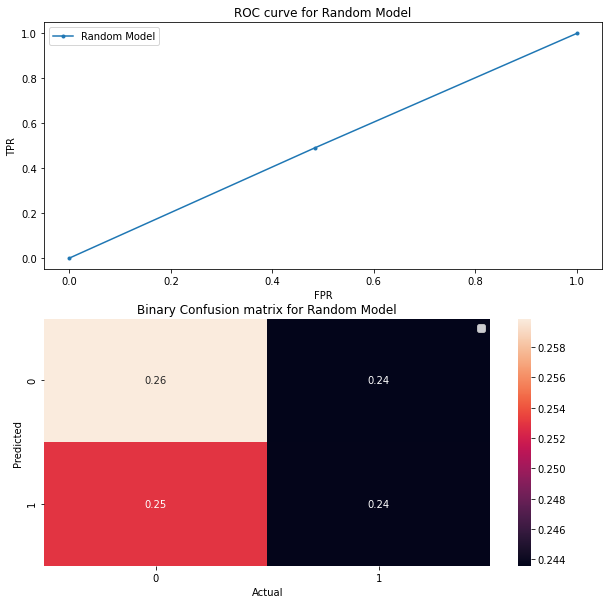

In [ ]:
metric(y_test,pre,name='Random Model')

we can observe that this model is not a very good model but works as a baseline model

#Logistic Regression

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] 
parameters={"alpha":alpha}
clf = SGDClassifier(penalty='l1',loss='log', random_state=42)
gd = GridSearchCV(clf, parameters,scoring='roc_auc')
gd.fit(x_train, y_train)
print(gd.best_params_)




{'alpha': 1e-05}


In [ ]:
clf = SGDClassifier(alpha=0.00001,penalty='l1',loss='log', random_state=42)
clf.fit(x_train, y_train)
Pkl_Filename = "log_reg.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)
from google.colab import files
files.download(Pkl_Filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

auc = 0.5249957997459084
macro f1 score = 0.4266876382865714


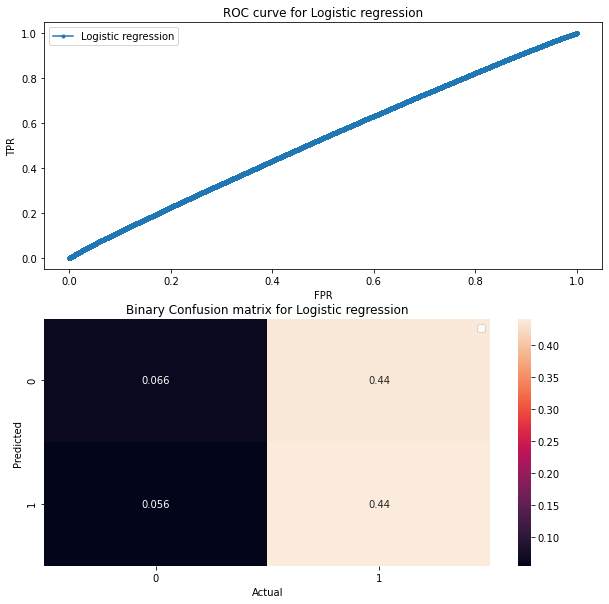

In [ ]:
pre=clf.predict_proba(x_test)
metric(y_test,pre[:,1],name='Logistic regression')

#Decision tree

In [ ]:
import random
lst=list(range(x_train.shape[0]))
lst=random.sample(lst, int(0.1*x_train.shape[0]))


In [ ]:
y_train.iloc[lst].shape

(155332,)

In [ ]:
alpha = [2,4,6,8,10,12]
parameters={"max_depth":alpha}
clf = DecisionTreeClassifier(criterion='gini',random_state=0)

gd = GridSearchCV(clf, parameters,scoring='roc_auc')
gd.fit(x_train[lst], y_train.iloc[lst])
print(gd.best_params_)


{'max_depth': 8}


In [ ]:
clf = DecisionTreeClassifier(max_depth= 8,criterion='gini',random_state=0)
clf.fit(x_train, y_train)
Pkl_Filename = "dt_cla.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)
from google.colab import files
files.download(Pkl_Filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

auc = 0.5155388674899017
macro f1 score = 0.49179961611917333


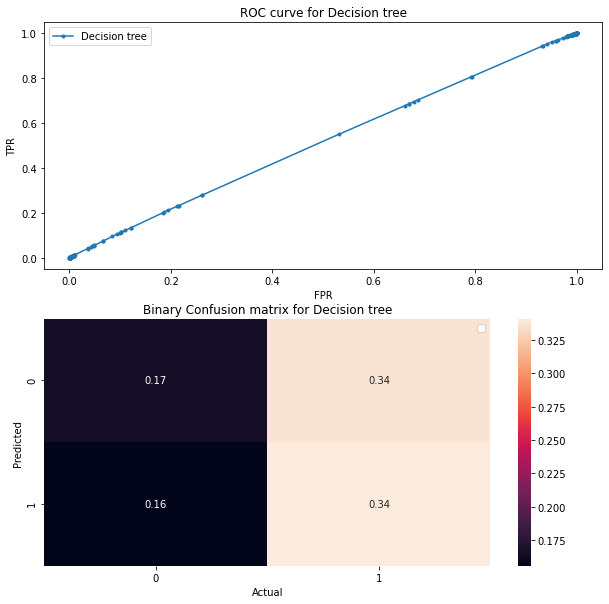

In [ ]:
pre=clf.predict_proba(x_test)
metric(y_test,pre[:,1],name='Decision tree')

# random forest

In [ ]:
alpha = [100,200,500,1000,2000]
parameters={"n_estimators":alpha,'max_depth':[5,10]}
clf = RandomForestClassifier( criterion='gini', random_state=42, n_jobs=-1)

gd = GridSearchCV(clf, parameters,scoring='roc_auc')
gd.fit(x_train[lst], y_train.iloc[lst])
print(gd.best_params_)
  

{'max_depth': 10, 'n_estimators': 2000}


In [ ]:
clf = RandomForestClassifier(n_estimators=2000,max_depth=10, criterion='gini', random_state=42, n_jobs=-1)
clf.fit(x_train, y_train)
Pkl_Filename = "rf.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)
from google.colab import files
files.download(Pkl_Filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

auc = 0.5307060780861945
macro f1 score = 0.5128715317312825


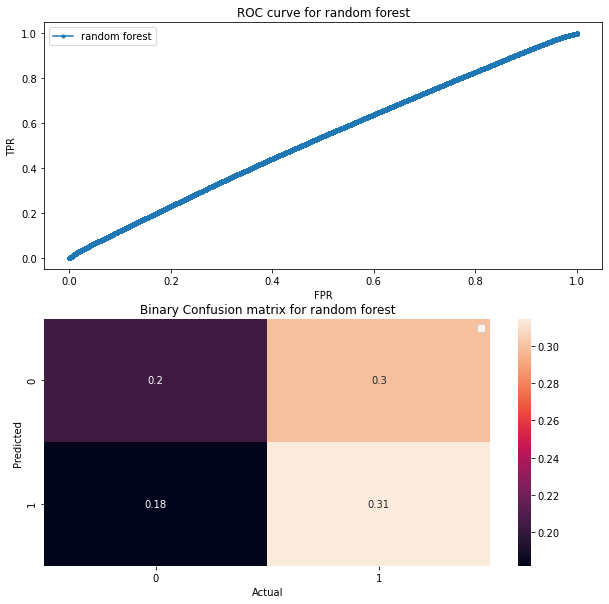

In [ ]:
pre=clf.predict_proba(x_test)
metric(y_test,pre[:,1],name='random forest')

#XGBoost

In [ ]:
alpha = [100,200,500]
parameters={"n_estimators":alpha,'max_depth':[5,7,9,11,13,15]}
clf = XGBClassifier(nthread=multiprocessing.cpu_count())

gd = GridSearchCV(clf, parameters,scoring='roc_auc')
gd.fit(x_train[lst], y_train.iloc[lst])
print(gd.best_params_)

{'max_depth': 500, 'n_estimators': 11}

In [ ]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=11,
    nthread=multiprocessing.cpu_count()
)
clf.fit(x_train, y_train)
Pkl_Filename = "XGB.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)
from google.colab import files
files.download(Pkl_Filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

auc = 0.5251360413791621
macro f1 score = 0.5158633918348878


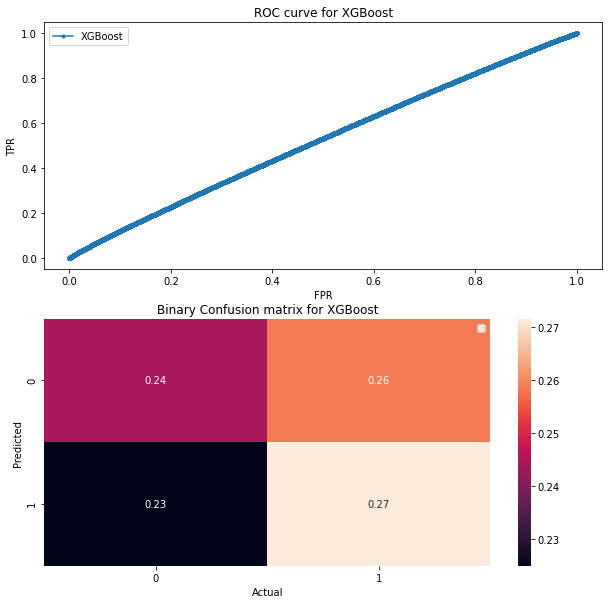

In [ ]:
pre=clf.predict_proba(x_test)
metric(y_test,pre[:,1],name='XGBoost')

#summary of all models

The best model was obtained by using Random forest where the AUC  was .53 and followed by XGBoost where AUC was 0.526

In [ ]:
print('---------------------------')
print('|basline model| AUC = 0.503 |')
print('|---------------------------|')
print('|logistic reg | AUC = 0.524 |')
print('|---------------------------|')
print('|Decision tree| AUC = 0.515 |')
print('|---------------------------|')
print('|Random forest| AUC = 0.530 |')
print('|---------------------------|')
print('|XGBoost      | AUC = 0.526 |')
print('----------------------------')




---------------------------
|basline model| AUC = 0.503 |
|---------------------------|
|logistic reg | AUC = 0.524 |
|---------------------------|
|Decision tree| AUC = 0.515 |
|---------------------------|
|Random forest| AUC = 0.530 |
|---------------------------|
|XGBoost      | AUC = 0.526 |
----------------------------
